In [2]:
# ============================================================================
# CELL 1: Imports & Configuration
# ============================================================================

# Suppress TensorFlow/CUDA warnings and protobuf noise
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # Suppress TensorFlow logging (0=all, 3=errors only)
os.environ['CUDA_VISIBLE_DEVICES'] = '0'  # Use first GPU if available

import warnings
warnings.filterwarnings('ignore')

# Suppress protobuf/absl warnings
import logging
logging.getLogger('tensorflow').setLevel(logging.ERROR)
logging.getLogger('absl').setLevel(logging.ERROR)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler

# Deep learning imports
try:
    import tensorflow as tf
    tf.get_logger().setLevel('ERROR')  # Additional TF logging suppression
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout
    from tensorflow.keras.callbacks import EarlyStopping
    DEEP_LEARNING_AVAILABLE = True
    print("✓ TensorFlow/Keras available")
except ImportError:
    DEEP_LEARNING_AVAILABLE = False
    print("✗ TensorFlow not available - LSTM/GRU will be skipped")

# XGBoost import
try:
    import xgboost as xgb
    XGBOOST_AVAILABLE = True
    print("✓ XGBoost available")
except ImportError:
    XGBOOST_AVAILABLE = False
    print("✗ XGBoost not available - will be skipped")

# Statistical tests
from scipy import stats

# Configuration
np.random.seed(42)
if DEEP_LEARNING_AVAILABLE:
    tf.random.set_seed(42)

CONFIG = {
    'DATA_PATH': '/kaggle/input/green-computing-cse407/planetlab-workload-traces-master',
    'HISTORY_WINDOW': 10,  # H = number of past points to use
    'TRAIN_RATIO': 0.7,
    'MIN_TRACE_LENGTH': 288,
    'TARGET_LENGTH': 288,
    'DPI': 300,
    'FIGURE_SIZE': (12, 6),
    'N_SUBSETS': 3,  # Number of random subsets for robustness
    'VMS_PER_SUBSET': 30,  # VMs per subset
    'HOST_CAPACITY': 100.0,  # Total CPU capacity per host (%)
    'OVERLOAD_THRESHOLD': 80.0,  # Host overload threshold (%)
    'POWER_IDLE': 162.0,  # Watts
    'POWER_MAX': 215.0,   # Watts
}

print("\n" + "="*70)
print("GREEN COMPUTING - VM CONSOLIDATION WITH ADVANCED PREDICTION MODELS")
print("="*70)
print(f"\nConfiguration:")
for key, val in CONFIG.items():
    print(f"  {key}: {val}")
print("="*70 + "\n")

✓ TensorFlow/Keras available
✓ XGBoost available

GREEN COMPUTING - VM CONSOLIDATION WITH ADVANCED PREDICTION MODELS

Configuration:
  DATA_PATH: /kaggle/input/green-computing-cse407/planetlab-workload-traces-master
  HISTORY_WINDOW: 10
  TRAIN_RATIO: 0.7
  MIN_TRACE_LENGTH: 288
  TARGET_LENGTH: 288
  DPI: 300
  FIGURE_SIZE: (12, 6)
  N_SUBSETS: 3
  VMS_PER_SUBSET: 30
  HOST_CAPACITY: 100.0
  OVERLOAD_THRESHOLD: 80.0
  POWER_IDLE: 162.0
  POWER_MAX: 215.0



In [3]:
# ============================================================================
# CELL 1: Imports & Configuration
# ============================================================================

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings('ignore')

# Deep learning imports
try:
    import tensorflow as tf
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout
    from tensorflow.keras.callbacks import EarlyStopping
    DEEP_LEARNING_AVAILABLE = True
    print("✓ TensorFlow/Keras available")
except ImportError:
    DEEP_LEARNING_AVAILABLE = False
    print("✗ TensorFlow not available - LSTM/GRU will be skipped")

# XGBoost import
try:
    import xgboost as xgb
    XGBOOST_AVAILABLE = True
    print("✓ XGBoost available")
except ImportError:
    XGBOOST_AVAILABLE = False
    print("✗ XGBoost not available - will be skipped")

# Statistical tests
from scipy import stats

# Configuration
np.random.seed(42)
if DEEP_LEARNING_AVAILABLE:
    tf.random.set_seed(42)

CONFIG = {
    'DATA_PATH': '/kaggle/input/green-computing-cse407/planetlab-workload-traces-master',
    'HISTORY_WINDOW': 10,  # H = number of past points to use
    'TRAIN_RATIO': 0.7,
    'MIN_TRACE_LENGTH': 288,
    'TARGET_LENGTH': 288,
    'DPI': 300,
    'FIGURE_SIZE': (12, 6),
    'N_SUBSETS': 3,  # Number of random subsets for robustness
    'VMS_PER_SUBSET': 30,  # VMs per subset
    'HOST_CAPACITY': 100.0,  # Total CPU capacity per host (%)
    'OVERLOAD_THRESHOLD': 80.0,  # Host overload threshold (%)
    'POWER_IDLE': 162.0,  # Watts
    'POWER_MAX': 215.0,   # Watts
}

print("\n" + "="*70)
print("GREEN COMPUTING - VM CONSOLIDATION WITH ADVANCED PREDICTION MODELS")
print("="*70)
print(f"\nConfiguration:")
for key, val in CONFIG.items():
    print(f"  {key}: {val}")
print("="*70 + "\n")

✓ TensorFlow/Keras available
✓ XGBoost available

GREEN COMPUTING - VM CONSOLIDATION WITH ADVANCED PREDICTION MODELS

Configuration:
  DATA_PATH: /kaggle/input/green-computing-cse407/planetlab-workload-traces-master
  HISTORY_WINDOW: 10
  TRAIN_RATIO: 0.7
  MIN_TRACE_LENGTH: 288
  TARGET_LENGTH: 288
  DPI: 300
  FIGURE_SIZE: (12, 6)
  N_SUBSETS: 3
  VMS_PER_SUBSET: 30
  HOST_CAPACITY: 100.0
  OVERLOAD_THRESHOLD: 80.0
  POWER_IDLE: 162.0
  POWER_MAX: 215.0



In [4]:
# ============================================================================
# CELL 2: Load & Prepare Data
# ============================================================================

def load_planetlab_traces(data_path, min_length=288, target_length=288):
    """
    Load PlanetLab traces from nested date folders.
    Returns: dict {vm_id: np.array of CPU utilization}
    """
    traces = {}
    date_folders = sorted([d for d in os.listdir(data_path) 
                          if os.path.isdir(os.path.join(data_path, d)) and d.startswith('2011')])
    
    print(f"Loading traces from {len(date_folders)} date folders...")
    
    for date_folder in date_folders:
        date_path = os.path.join(data_path, date_folder)
        vm_files = [f for f in os.listdir(date_path) 
                   if os.path.isfile(os.path.join(date_path, f))]
        
        for vm_file in vm_files:
            vm_path = os.path.join(date_path, vm_file)
            try:
                data = np.loadtxt(vm_path)
                if len(data) >= min_length:
                    # Normalize to target length
                    if len(data) > target_length:
                        data = data[:target_length]
                    elif len(data) < target_length:
                        data = np.pad(data, (0, target_length - len(data)), 
                                     mode='edge')
                    
                    # Clip to valid range
                    data = np.clip(data, 0, 100)
                    
                    vm_id = f"{date_folder}_{vm_file}"
                    traces[vm_id] = data
            except:
                continue
    
    print(f"✓ Loaded {len(traces)} VM traces")
    return traces

# Load data
all_traces = load_planetlab_traces(
    CONFIG['DATA_PATH'],
    min_length=CONFIG['MIN_TRACE_LENGTH'],
    target_length=CONFIG['TARGET_LENGTH']
)

# Create random subsets for robustness
np.random.seed(42)
all_vm_ids = list(all_traces.keys())
np.random.shuffle(all_vm_ids)

subsets = []
for i in range(CONFIG['N_SUBSETS']):
    start_idx = i * CONFIG['VMS_PER_SUBSET']
    end_idx = start_idx + CONFIG['VMS_PER_SUBSET']
    subset_ids = all_vm_ids[start_idx:end_idx]
    subset_traces = {vm_id: all_traces[vm_id] for vm_id in subset_ids}
    subsets.append(subset_traces)
    print(f"  Subset {i+1}: {len(subset_traces)} VMs")

print(f"\n✓ Created {len(subsets)} subsets for evaluation")

Loading traces from 10 date folders...
✓ Loaded 11746 VM traces
  Subset 1: 30 VMs
  Subset 2: 30 VMs
  Subset 3: 30 VMs

✓ Created 3 subsets for evaluation


In [5]:
# ============================================================================
# CELL 3: Feature Engineering (Sliding Window)
# ============================================================================

def create_sliding_window_features(trace, history_window=10):
    """
    Convert time series into supervised learning problem.
    X: [u(t-H), u(t-H+1), ..., u(t-1)]
    y: u(t)
    """
    X, y = [], []
    for i in range(history_window, len(trace)):
        X.append(trace[i-history_window:i])
        y.append(trace[i])
    return np.array(X), np.array(y)

def prepare_dataset(traces, history_window=10, train_ratio=0.7):
    """
    Prepare train/test split for all VMs in a subset.
    Returns: X_train, y_train, X_test, y_test (concatenated across all VMs)
    """
    X_train_all, y_train_all = [], []
    X_test_all, y_test_all = [], []
    
    for vm_id, trace in traces.items():
        X, y = create_sliding_window_features(trace, history_window)
        
        # Split
        split_idx = int(len(X) * train_ratio)
        X_train_all.append(X[:split_idx])
        y_train_all.append(y[:split_idx])
        X_test_all.append(X[split_idx:])
        y_test_all.append(y[split_idx:])
    
    X_train = np.vstack(X_train_all)
    y_train = np.hstack(y_train_all)
    X_test = np.vstack(X_test_all)
    y_test = np.hstack(y_test_all)
    
    return X_train, y_train, X_test, y_test

# Prepare datasets for all subsets
datasets = []
for i, subset in enumerate(subsets):
    X_train, y_train, X_test, y_test = prepare_dataset(
        subset,
        history_window=CONFIG['HISTORY_WINDOW'],
        train_ratio=CONFIG['TRAIN_RATIO']
    )
    datasets.append({
        'X_train': X_train,
        'y_train': y_train,
        'X_test': X_test,
        'y_test': y_test,
        'traces': subset
    })
    print(f"Subset {i+1}: Train={X_train.shape}, Test={X_test.shape}")

print(f"\n✓ Feature engineering complete")

Subset 1: Train=(5820, 10), Test=(2520, 10)
Subset 2: Train=(5820, 10), Test=(2520, 10)
Subset 3: Train=(5820, 10), Test=(2520, 10)

✓ Feature engineering complete


In [6]:
# ============================================================================
# CELL 4: Train All Models
# ============================================================================

def train_naive_persistence(X_train, y_train):
    """Naive: predict u(t) = u(t-1)"""
    return {'type': 'naive'}

def train_knn(X_train, y_train, k=10):
    """KNN Regressor"""
    model = KNeighborsRegressor(n_neighbors=k, weights='distance')
    model.fit(X_train, y_train)
    return model

def train_random_forest(X_train, y_train):
    """Random Forest Regressor"""
    model = RandomForestRegressor(
        n_estimators=100,
        max_depth=15,
        min_samples_split=10,
        random_state=42,
        n_jobs=-1
    )
    model.fit(X_train, y_train)
    return model

def train_xgboost(X_train, y_train):
    """XGBoost Regressor"""
    model = xgb.XGBRegressor(
        n_estimators=100,
        max_depth=6,
        learning_rate=0.1,
        random_state=42,
        n_jobs=-1
    )
    model.fit(X_train, y_train)
    return model

def train_lstm(X_train, y_train, X_test, y_test):
    """LSTM model"""
    # Reshape for LSTM: (samples, timesteps, features)
    X_train_lstm = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    X_test_lstm = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
    
    model = Sequential([
        LSTM(50, activation='relu', return_sequences=True, 
             input_shape=(X_train.shape[1], 1)),
        Dropout(0.2),
        LSTM(50, activation='relu'),
        Dropout(0.2),
        Dense(1)
    ])
    
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    
    early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    
    model.fit(
        X_train_lstm, y_train,
        validation_data=(X_test_lstm, y_test),
        epochs=50,
        batch_size=64,
        callbacks=[early_stop],
        verbose=0
    )
    
    return model

def train_gru(X_train, y_train, X_test, y_test):
    """GRU model"""
    X_train_gru = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    X_test_gru = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
    
    model = Sequential([
        GRU(50, activation='relu', return_sequences=True,
            input_shape=(X_train.shape[1], 1)),
        Dropout(0.2),
        GRU(50, activation='relu'),
        Dropout(0.2),
        Dense(1)
    ])
    
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    
    early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    
    model.fit(
        X_train_gru, y_train,
        validation_data=(X_test_gru, y_test),
        epochs=50,
        batch_size=64,
        callbacks=[early_stop],
        verbose=0
    )
    
    return model

def predict_model(model, X_test, model_type='sklearn'):
    """Universal prediction function"""
    if isinstance(model, dict) and model.get('type') == 'naive':
        # Naive: use last value
        return X_test[:, -1]
    elif model_type in ['lstm', 'gru']:
        X_test_reshaped = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
        return model.predict(X_test_reshaped, verbose=0).flatten()
    else:
        return model.predict(X_test)

# Train all models on all subsets
print("Training models on all subsets...\n")

all_models = []

for subset_idx, dataset in enumerate(datasets):
    print(f"=== Subset {subset_idx + 1} ===")
    
    X_train = dataset['X_train']
    y_train = dataset['y_train']
    X_test = dataset['X_test']
    y_test = dataset['y_test']
    
    models = {}
    
    # Naive
    print("  Training Naive Persistence...")
    models['Naive'] = train_naive_persistence(X_train, y_train)
    
    # KNN (multiple K values)
    for k in [3, 5, 10]:
        print(f"  Training KNN (K={k})...")
        models[f'KNN-{k}'] = train_knn(X_train, y_train, k=k)
    
    # Random Forest
    print("  Training Random Forest...")
    models['RandomForest'] = train_random_forest(X_train, y_train)
    
    # XGBoost
    if XGBOOST_AVAILABLE:
        print("  Training XGBoost...")
        models['XGBoost'] = train_xgboost(X_train, y_train)
    
    # LSTM
    if DEEP_LEARNING_AVAILABLE:
        print("  Training LSTM...")
        models['LSTM'] = train_lstm(X_train, y_train, X_test, y_test)
        
        print("  Training GRU...")
        models['GRU'] = train_gru(X_train, y_train, X_test, y_test)
    
    all_models.append(models)
    print()

print("✓ All models trained\n")

Training models on all subsets...

=== Subset 1 ===
  Training Naive Persistence...
  Training KNN (K=3)...
  Training KNN (K=5)...
  Training KNN (K=10)...
  Training Random Forest...
  Training XGBoost...
  Training LSTM...


I0000 00:00:1764747238.748233      47 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0
I0000 00:00:1764747242.747670     130 service.cc:148] XLA service 0x3d2dccc0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1764747242.748270     130 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1764747243.240554     130 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1764747245.150462     130 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


  Training GRU...

=== Subset 2 ===
  Training Naive Persistence...
  Training KNN (K=3)...
  Training KNN (K=5)...
  Training KNN (K=10)...
  Training Random Forest...
  Training XGBoost...
  Training LSTM...
  Training GRU...

=== Subset 3 ===
  Training Naive Persistence...
  Training KNN (K=3)...
  Training KNN (K=5)...
  Training KNN (K=10)...
  Training Random Forest...
  Training XGBoost...
  Training LSTM...
  Training GRU...

✓ All models trained



In [7]:
# ============================================================================
# CELL 5: Evaluate Prediction Performance
# ============================================================================

def evaluate_predictions(y_true, y_pred):
    """Calculate all prediction metrics"""
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    
    # Mean Absolute Percentage Error (MAPE)
    # Avoid division by zero
    mask = y_true > 1e-6
    mape = np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100 if mask.sum() > 0 else np.nan
    
    return {
        'MAE': mae,
        'RMSE': rmse,
        'R2': r2,
        'MAPE': mape
    }

# Evaluate all models
results = []

for subset_idx, (dataset, models) in enumerate(zip(datasets, all_models)):
    X_test = dataset['X_test']
    y_test = dataset['y_test']
    
    for model_name, model in models.items():
        # Determine model type
        if 'LSTM' in model_name or 'GRU' in model_name:
            model_type = model_name.lower()
        else:
            model_type = 'sklearn'
        
        # Predict
        y_pred = predict_model(model, X_test, model_type=model_type)
        
        # Evaluate
        metrics = evaluate_predictions(y_test, y_pred)
        
        results.append({
            'Subset': subset_idx + 1,
            'Model': model_name,
            'MAE': metrics['MAE'],
            'RMSE': metrics['RMSE'],
            'R2': metrics['R2'],
            'MAPE': metrics['MAPE']
        })

# Create DataFrame
results_df = pd.DataFrame(results)

# Aggregate across subsets
summary_stats = results_df.groupby('Model').agg({
    'MAE': ['mean', 'std'],
    'RMSE': ['mean', 'std'],
    'R2': ['mean', 'std'],
    'MAPE': ['mean', 'std']
}).round(4)

print("="*80)
print("PREDICTION PERFORMANCE SUMMARY (Mean ± Std across subsets)")
print("="*80)
print(summary_stats)
print("="*80 + "\n")

# Save for later use
results_df.to_csv('prediction_results.csv', index=False)
summary_stats.to_csv('prediction_summary.csv')
print("✓ Results saved to CSV\n")

PREDICTION PERFORMANCE SUMMARY (Mean ± Std across subsets)
                 MAE             RMSE              R2             MAPE  \
                mean     std     mean     std    mean     std     mean   
Model                                                                    
GRU           4.6498  0.6483   8.9241  0.7645  0.5722  0.2470  62.9092   
KNN-10        4.8947  0.5803   9.1990  0.6598  0.5399  0.2740  69.2613   
KNN-3         5.3074  0.6211   9.9925  0.7297  0.4542  0.3324  78.8068   
KNN-5         5.1086  0.6048   9.5582  0.7103  0.5015  0.3020  73.6970   
LSTM          4.8108  0.8319   9.0748  1.0141  0.5686  0.2280  64.4144   
Naive         5.8837  0.7896  12.0075  0.9393  0.2225  0.4513  93.6466   
RandomForest  4.9035  0.6390   9.1343  0.6360  0.5496  0.2592  70.5345   
XGBoost       4.9189  0.6618   9.3085  0.6474  0.5350  0.2602  68.0219   

                       
                  std  
Model                  
GRU            5.8847  
KNN-10         7.8895  
KNN-3 

In [8]:
# ============================================================================
# CELL 6: Statistical Comparison (Wilcoxon Signed-Rank Test)
# ============================================================================

def compute_effect_size(group1, group2):
    """Cohen's d effect size"""
    mean_diff = np.mean(group1) - np.mean(group2)
    pooled_std = np.sqrt((np.std(group1)**2 + np.std(group2)**2) / 2)
    return mean_diff / pooled_std if pooled_std > 0 else 0

# Statistical comparison: each model vs Naive baseline
print("="*80)
print("STATISTICAL SIGNIFICANCE TESTS (vs Naive Baseline)")
print("="*80)

naive_mae = results_df[results_df['Model'] == 'Naive']['MAE'].values
models_to_compare = [m for m in results_df['Model'].unique() if m != 'Naive']

stat_results = []

for model_name in models_to_compare:
    model_mae = results_df[results_df['Model'] == model_name]['MAE'].values
    
    # Wilcoxon signed-rank test (paired, non-parametric)
    if len(model_mae) == len(naive_mae) and len(model_mae) > 1:
        stat, p_value = stats.wilcoxon(naive_mae, model_mae, alternative='greater')
        effect_size = compute_effect_size(naive_mae, model_mae)
        
        significance = "***" if p_value < 0.001 else ("**" if p_value < 0.01 else ("*" if p_value < 0.05 else "ns"))
        
        stat_results.append({
            'Model': model_name,
            'Mean_MAE': model_mae.mean(),
            'vs_Naive_Δ': naive_mae.mean() - model_mae.mean(),
            'p_value': p_value,
            'Significance': significance,
            'Effect_Size': effect_size
        })

stat_df = pd.DataFrame(stat_results).sort_values('Mean_MAE')
print(stat_df.to_string(index=False))
print("\nSignificance: *** p<0.001, ** p<0.01, * p<0.05, ns = not significant")
print("="*80 + "\n")

stat_df.to_csv('statistical_comparison.csv', index=False)

STATISTICAL SIGNIFICANCE TESTS (vs Naive Baseline)
       Model  Mean_MAE  vs_Naive_Δ  p_value Significance  Effect_Size
         GRU  4.649760    1.233970    0.125           ns     2.092061
        LSTM  4.810799    1.072931    0.125           ns     1.620294
      KNN-10  4.894716    0.989014    0.125           ns     1.748209
RandomForest  4.903451    0.980279    0.125           ns     1.671620
     XGBoost  4.918928    0.964802    0.125           ns     1.622088
       KNN-5  5.108595    0.775136    0.125           ns     1.349856
       KNN-3  5.307402    0.576328    0.125           ns     0.993709

Significance: *** p<0.001, ** p<0.01, * p<0.05, ns = not significant



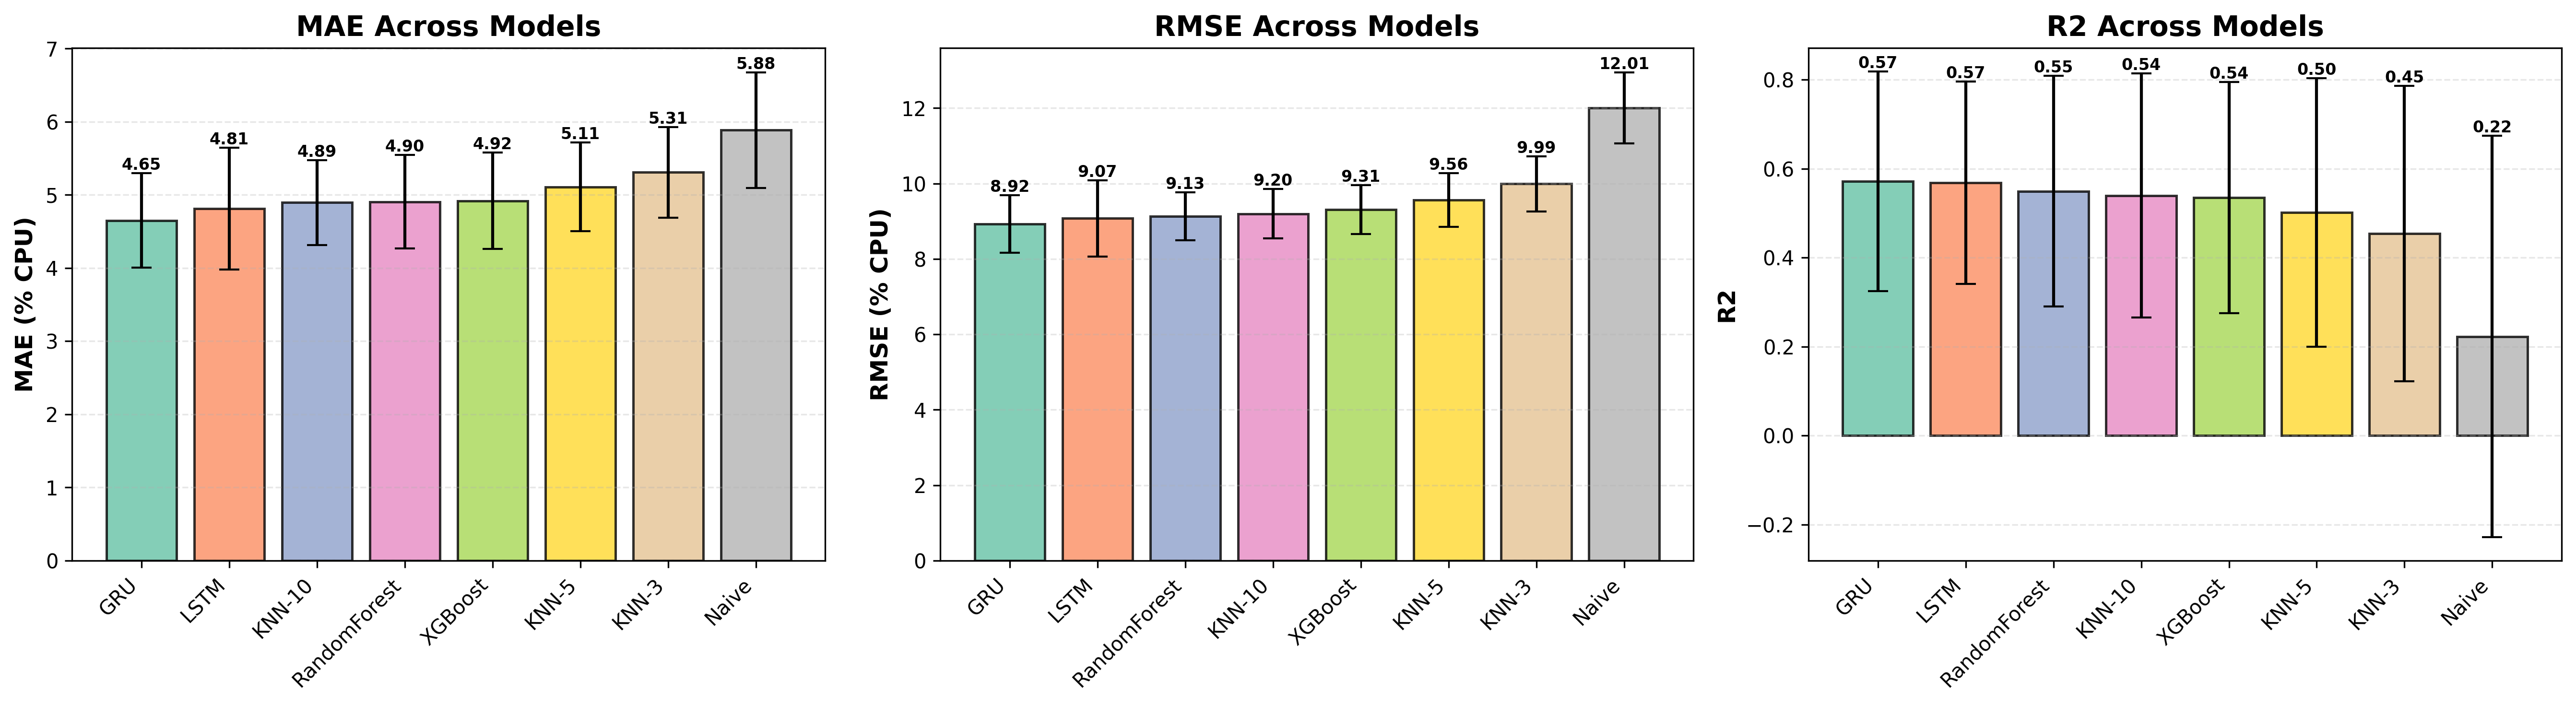

✓ Figure 1 saved: Figure1_Prediction_Performance.png



In [9]:
# ============================================================================
# CELL 7: Figure 1 - Prediction Performance Comparison
# ============================================================================

fig, axes = plt.subplots(1, 3, figsize=(18, 5), dpi=CONFIG['DPI'])

metrics = ['MAE', 'RMSE', 'R2']
colors = sns.color_palette("Set2", n_colors=len(results_df['Model'].unique()))

for idx, metric in enumerate(metrics):
    ax = axes[idx]
    
    # Prepare data
    plot_data = results_df.pivot(index='Subset', columns='Model', values=metric)
    
    # Sort models by mean performance
    model_order = results_df.groupby('Model')[metric].mean().sort_values(ascending=(metric != 'R2')).index
    plot_data = plot_data[model_order]
    
    # Bar plot with error bars
    means = plot_data.mean()
    stds = plot_data.std()
    
    x_pos = np.arange(len(means))
    bars = ax.bar(x_pos, means, yerr=stds, capsize=5, alpha=0.8, 
                   color=colors[:len(means)], edgecolor='black', linewidth=1.2)
    
    ax.set_xticks(x_pos)
    ax.set_xticklabels(means.index, rotation=45, ha='right', fontsize=10)
    ax.set_ylabel(f'{metric} (% CPU)' if metric != 'R2' else metric, fontsize=12, fontweight='bold')
    ax.set_title(f'{metric} Across Models', fontsize=14, fontweight='bold')
    ax.grid(axis='y', alpha=0.3, linestyle='--')
    
    # Add value labels on bars
    for i, (bar, mean, std) in enumerate(zip(bars, means, stds)):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + std,
                f'{mean:.2f}', ha='center', va='bottom', fontsize=8, fontweight='bold')

plt.tight_layout()
plt.savefig('Figure1_Prediction_Performance.png', dpi=CONFIG['DPI'], bbox_inches='tight')
plt.show()

print("✓ Figure 1 saved: Figure1_Prediction_Performance.png\n")

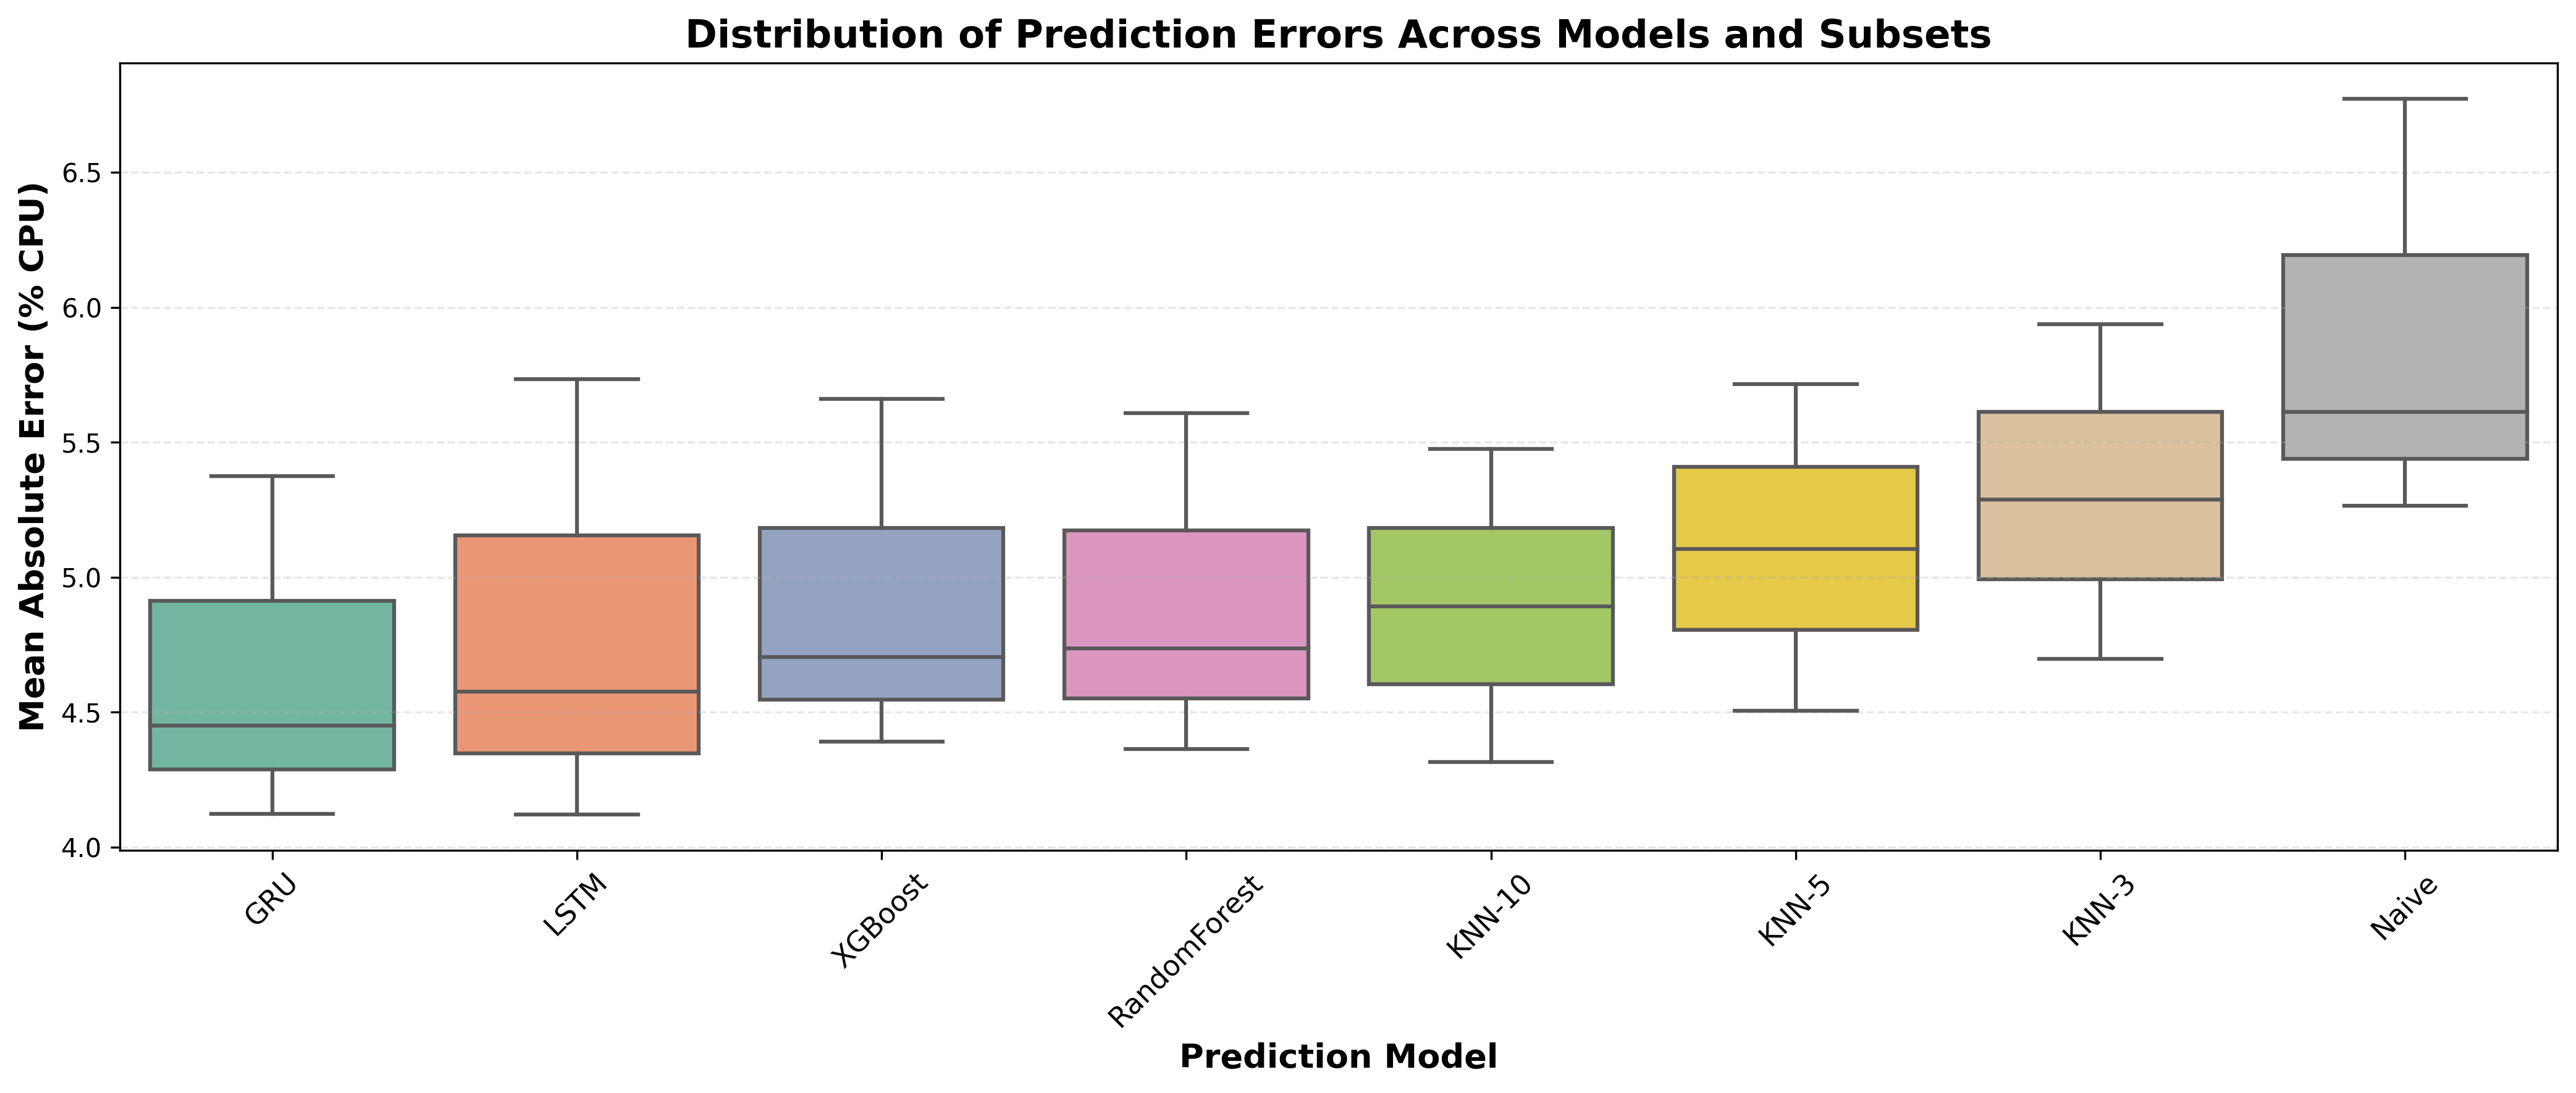

✓ Figure 2 saved: Figure2_Error_Distribution.png



In [10]:
# ============================================================================
# CELL 8: Figure 2 - Prediction Error Distribution (Box Plot)
# ============================================================================

fig, ax = plt.subplots(figsize=(14, 6), dpi=CONFIG['DPI'])

# Sort models by median MAE
model_order = results_df.groupby('Model')['MAE'].median().sort_values().index

sns.boxplot(
    data=results_df,
    x='Model',
    y='MAE',
    order=model_order,
    palette='Set2',
    ax=ax,
    linewidth=1.5
)

ax.set_xlabel('Prediction Model', fontsize=13, fontweight='bold')
ax.set_ylabel('Mean Absolute Error (% CPU)', fontsize=13, fontweight='bold')
ax.set_title('Distribution of Prediction Errors Across Models and Subsets', 
             fontsize=15, fontweight='bold')
ax.tick_params(axis='x', rotation=45, labelsize=11)
ax.grid(axis='y', alpha=0.3, linestyle='--')

plt.tight_layout()
plt.savefig('Figure2_Error_Distribution.png', dpi=CONFIG['DPI'], bbox_inches='tight')
plt.show()

print("✓ Figure 2 saved: Figure2_Error_Distribution.png\n")

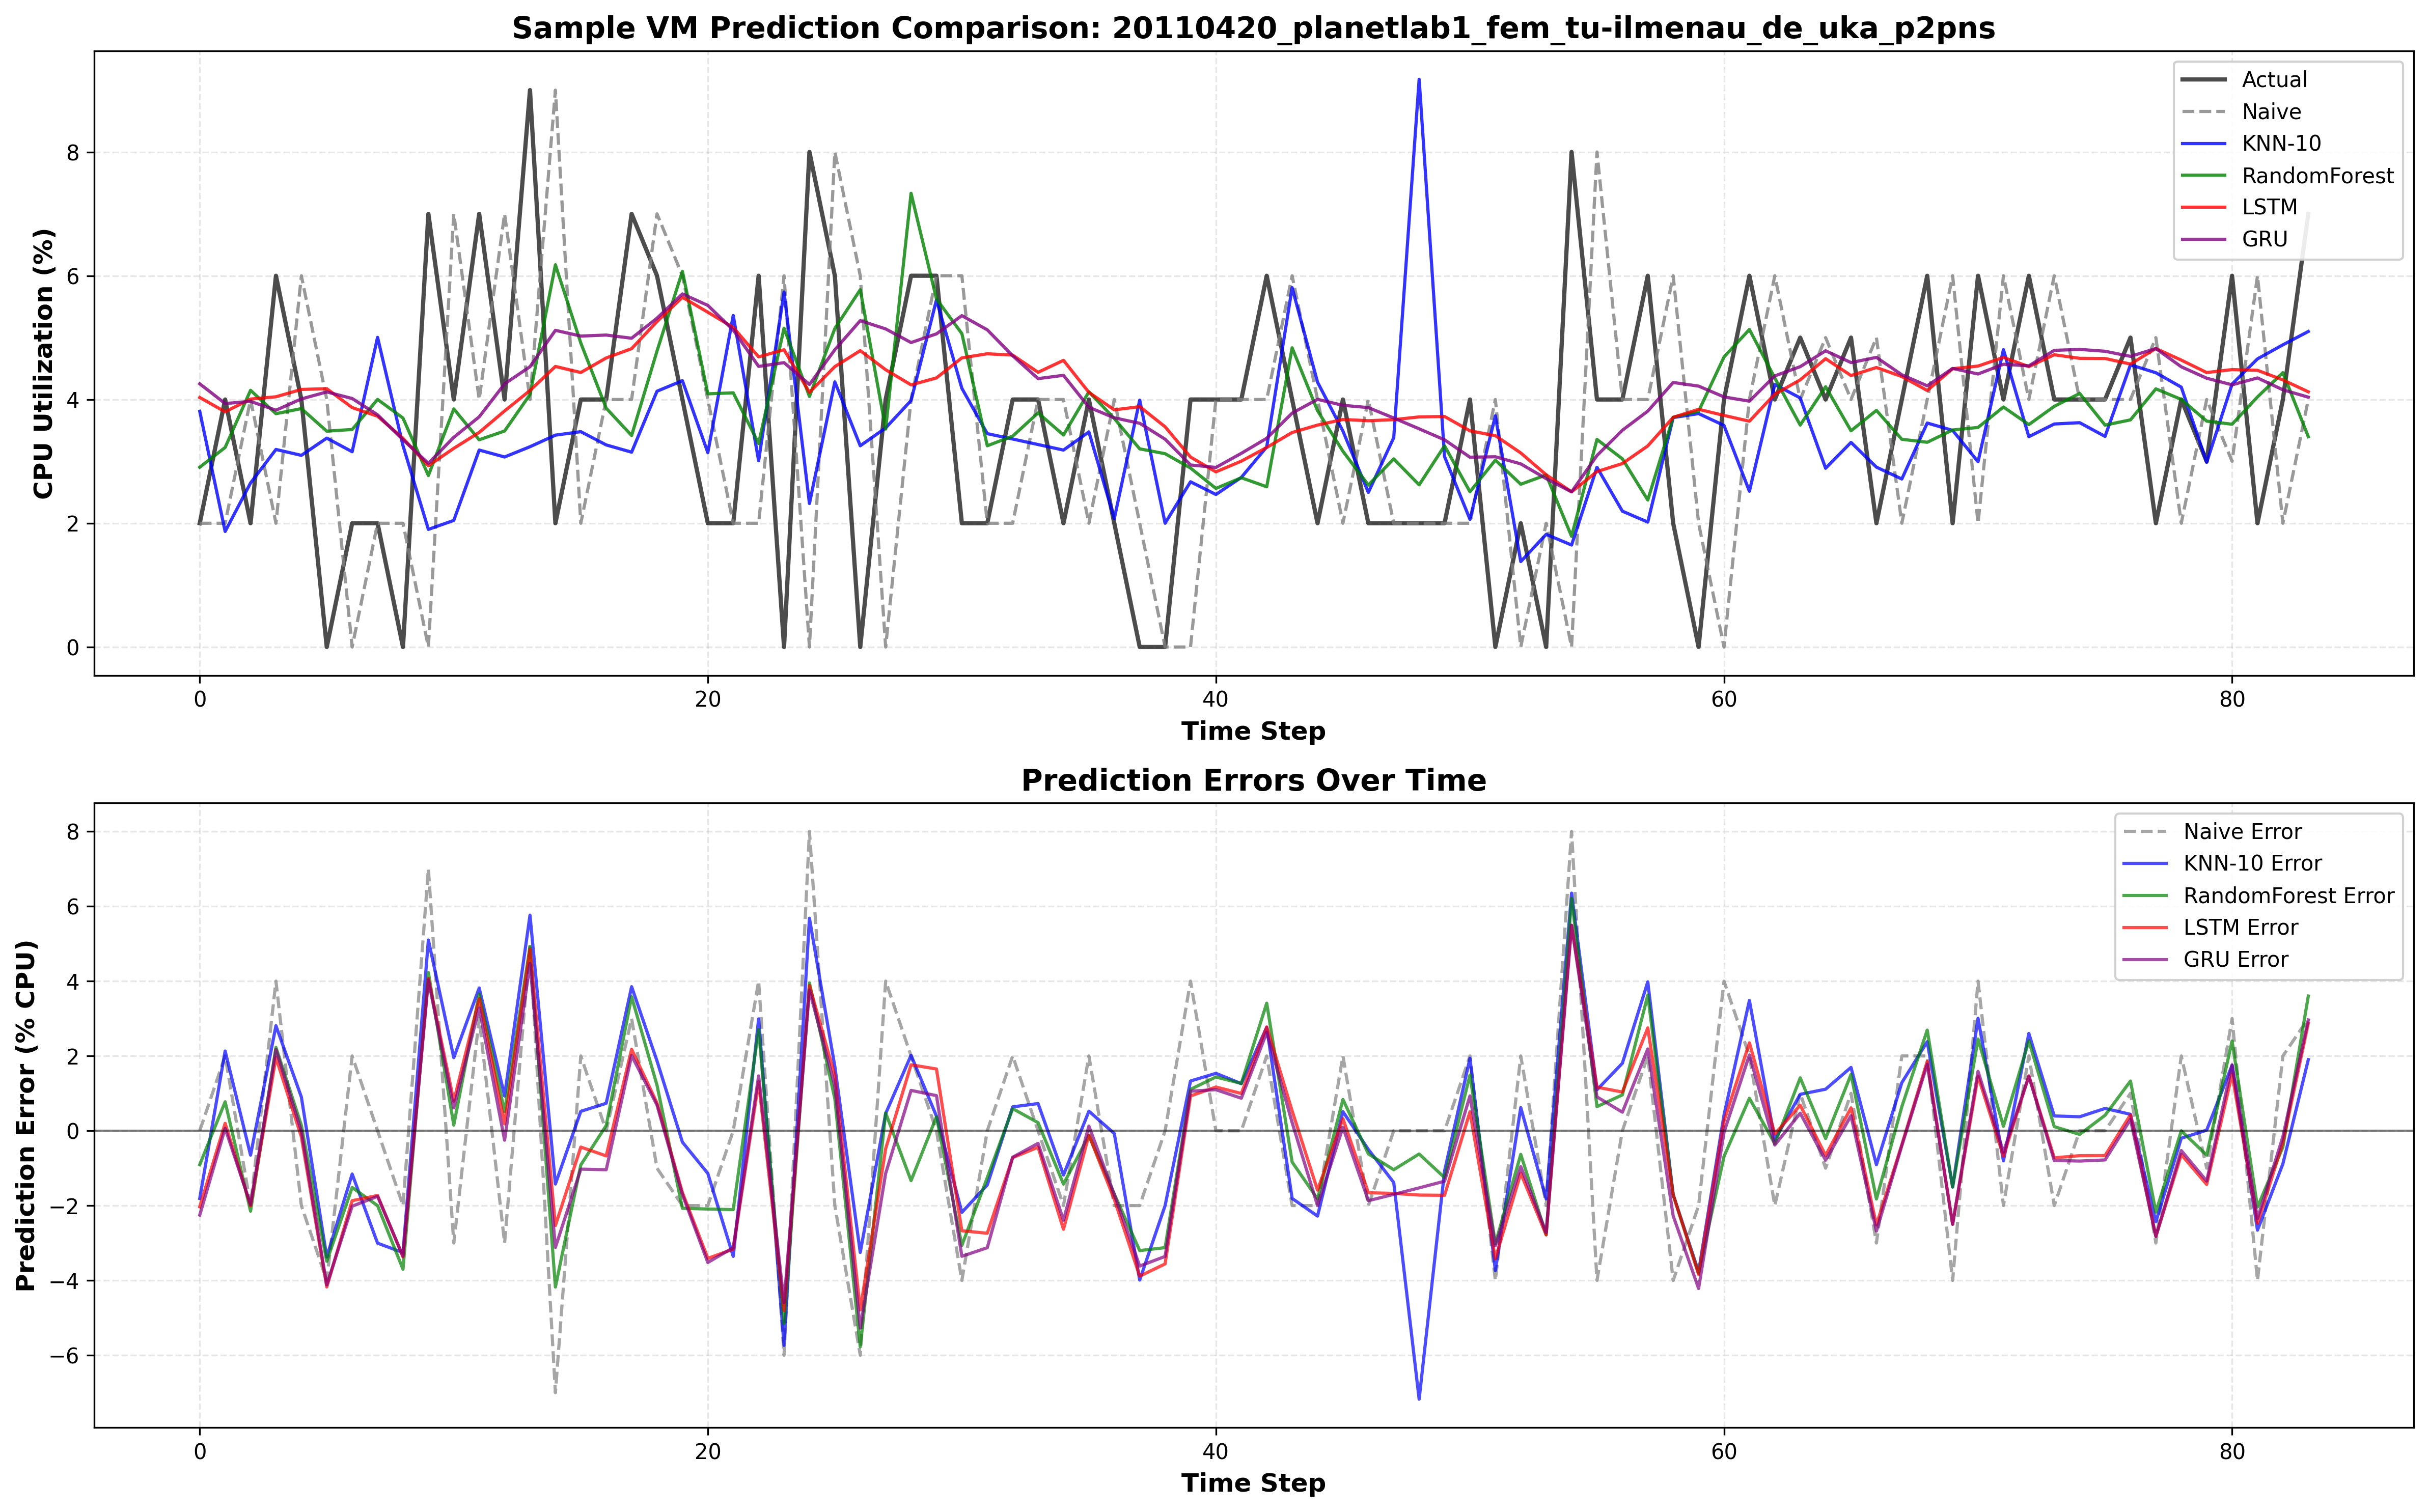

✓ Figure 3 saved: Figure3_Sample_Predictions.png



In [11]:
# ============================================================================
# CELL 9: Figure 3 - Sample Predictions Visualization
# ============================================================================

# Pick one VM from first subset for visualization
sample_vm_id = list(datasets[0]['traces'].keys())[0]
sample_trace = datasets[0]['traces'][sample_vm_id]

# Prepare features
X_sample, y_sample = create_sliding_window_features(sample_trace, CONFIG['HISTORY_WINDOW'])
split_idx = int(len(X_sample) * CONFIG['TRAIN_RATIO'])
X_test_sample = X_sample[split_idx:]
y_test_sample = y_sample[split_idx:]

# Get predictions from all models (first subset)
predictions = {'Actual': y_test_sample}

for model_name, model in all_models[0].items():
    if 'LSTM' in model_name or 'GRU' in model_name:
        model_type = model_name.lower()
    else:
        model_type = 'sklearn'
    
    y_pred = predict_model(model, X_test_sample, model_type=model_type)
    predictions[model_name] = y_pred

# Plot
fig, axes = plt.subplots(2, 1, figsize=(16, 10), dpi=CONFIG['DPI'])

# Top: All models
ax = axes[0]
time_steps = np.arange(len(y_test_sample))

ax.plot(time_steps, predictions['Actual'], 'k-', linewidth=2, label='Actual', alpha=0.7)

model_styles = {
    'Naive': ('--', 'gray'),
    'KNN-10': ('-', 'blue'),
    'RandomForest': ('-', 'green'),
    'LSTM': ('-', 'red'),
    'GRU': ('-', 'purple')
}

for model_name in ['Naive', 'KNN-10', 'RandomForest']:
    if model_name in predictions:
        style, color = model_styles.get(model_name, ('-', 'orange'))
        ax.plot(time_steps, predictions[model_name], style, 
                linewidth=1.5, label=model_name, alpha=0.8, color=color)

if 'LSTM' in predictions:
    ax.plot(time_steps, predictions['LSTM'], '-', linewidth=1.5, 
            label='LSTM', alpha=0.8, color='red')
if 'GRU' in predictions:
    ax.plot(time_steps, predictions['GRU'], '-', linewidth=1.5, 
            label='GRU', alpha=0.8, color='purple')

ax.set_xlabel('Time Step', fontsize=12, fontweight='bold')
ax.set_ylabel('CPU Utilization (%)', fontsize=12, fontweight='bold')
ax.set_title(f'Sample VM Prediction Comparison: {sample_vm_id}', 
             fontsize=14, fontweight='bold')
ax.legend(loc='upper right', fontsize=10, framealpha=0.9)
ax.grid(alpha=0.3, linestyle='--')

# Bottom: Prediction errors
ax = axes[1]

for model_name in ['Naive', 'KNN-10', 'RandomForest', 'LSTM', 'GRU']:
    if model_name in predictions:
        errors = predictions['Actual'] - predictions[model_name]
        style, color = model_styles.get(model_name, ('-', 'orange'))
        ax.plot(time_steps, errors, style, linewidth=1.5, 
                label=f'{model_name} Error', alpha=0.7, color=color)

ax.axhline(0, color='black', linestyle='-', linewidth=1, alpha=0.5)
ax.set_xlabel('Time Step', fontsize=12, fontweight='bold')
ax.set_ylabel('Prediction Error (% CPU)', fontsize=12, fontweight='bold')
ax.set_title('Prediction Errors Over Time', fontsize=14, fontweight='bold')
ax.legend(loc='upper right', fontsize=10, framealpha=0.9)
ax.grid(alpha=0.3, linestyle='--')

plt.tight_layout()
plt.savefig('Figure3_Sample_Predictions.png', dpi=CONFIG['DPI'], bbox_inches='tight')
plt.show()

print("✓ Figure 3 saved: Figure3_Sample_Predictions.png\n")

In [12]:
# ============================================================================
# CELL 10: VM Consolidation Algorithm
# ============================================================================

def calculate_host_power(utilization):
    """
    Linear power model: P = P_idle + (P_max - P_idle) * utilization
    """
    return CONFIG['POWER_IDLE'] + (CONFIG['POWER_MAX'] - CONFIG['POWER_IDLE']) * (utilization / 100.0)

def consolidate_vms(vm_utilizations, host_capacity=100.0, overload_threshold=80.0):
    """
    First Fit Decreasing (FFD) bin packing for VM consolidation.
    
    Args:
        vm_utilizations: dict {vm_id: predicted_utilization}
        host_capacity: total CPU capacity per host (%)
        overload_threshold: max allowed utilization per host (%)
    
    Returns:
        dict with consolidation results
    """
    # Sort VMs by utilization (descending)
    sorted_vms = sorted(vm_utilizations.items(), key=lambda x: x[1], reverse=True)
    
    hosts = []  # List of lists: each host contains [(vm_id, utilization), ...]
    host_utils = []  # Current utilization of each host
    
    # First Fit Decreasing
    for vm_id, vm_util in sorted_vms:
        placed = False
        
        # Try to place in existing host
        for i, host in enumerate(hosts):
            if host_utils[i] + vm_util <= overload_threshold:
                host.append((vm_id, vm_util))
                host_utils[i] += vm_util
                placed = True
                break
        
        # Create new host if needed
        if not placed:
            hosts.append([(vm_id, vm_util)])
            host_utils.append(vm_util)
    
    # Calculate metrics
    n_hosts = len(hosts)
    avg_utilization = np.mean(host_utils) if host_utils else 0
    
    # Energy calculation
    total_energy = sum(calculate_host_power(util) for util in host_utils)
    
    # SLA violations (hosts exceeding threshold)
    sla_violations = sum(1 for util in host_utils if util > overload_threshold)
    
    # Resource wastage
    total_capacity = n_hosts * host_capacity
    total_used = sum(host_utils)
    wastage = ((total_capacity - total_used) / total_capacity * 100) if total_capacity > 0 else 0
    
    return {
        'n_hosts': n_hosts,
        'host_utilizations': host_utils,
        'avg_utilization': avg_utilization,
        'total_energy': total_energy,
        'sla_violations': sla_violations,
        'resource_wastage': wastage,
        'hosts': hosts
    }

print("✓ Consolidation algorithm defined\n")

✓ Consolidation algorithm defined



In [13]:
# ============================================================================
# CELL 11: Consolidation Evaluation (All Models)
# ============================================================================

consolidation_results = []

for subset_idx, (dataset, models) in enumerate(zip(datasets, all_models)):
    print(f"Evaluating consolidation for Subset {subset_idx + 1}...")
    
    traces = dataset['traces']
    
    # For each model, predict next-step utilization for all VMs
    for model_name, model in models.items():
        vm_predictions = {}
        
        for vm_id, trace in traces.items():
            # Use last H points to predict next
            if len(trace) >= CONFIG['HISTORY_WINDOW'] + 1:
                X_last = trace[-CONFIG['HISTORY_WINDOW']:].reshape(1, -1)
                
                if 'LSTM' in model_name or 'GRU' in model_name:
                    model_type = model_name.lower()
                else:
                    model_type = 'sklearn'
                
                pred = predict_model(model, X_last, model_type=model_type)[0]
                vm_predictions[vm_id] = max(0, min(100, pred))  # Clip to [0, 100]
        
        # Run consolidation
        result = consolidate_vms(
            vm_predictions,
            host_capacity=CONFIG['HOST_CAPACITY'],
            overload_threshold=CONFIG['OVERLOAD_THRESHOLD']
        )
        
        consolidation_results.append({
            'Subset': subset_idx + 1,
            'Model': model_name,
            'N_Hosts': result['n_hosts'],
            'Avg_Utilization': result['avg_utilization'],
            'Total_Energy_W': result['total_energy'],
            'SLA_Violations': result['sla_violations'],
            'Resource_Wastage_%': result['resource_wastage']
        })

# Create DataFrame
consol_df = pd.DataFrame(consolidation_results)

# Aggregate
consol_summary = consol_df.groupby('Model').agg({
    'N_Hosts': ['mean', 'std'],
    'Avg_Utilization': ['mean', 'std'],
    'Total_Energy_W': ['mean', 'std'],
    'SLA_Violations': ['mean', 'std'],
    'Resource_Wastage_%': ['mean', 'std']
}).round(2)

print("\n" + "="*80)
print("CONSOLIDATION PERFORMANCE SUMMARY (Mean ± Std)")
print("="*80)
print(consol_summary)
print("="*80 + "\n")

# Calculate energy savings vs Naive baseline
naive_energy = consol_df[consol_df['Model'] == 'Naive']['Total_Energy_W'].mean()

energy_savings = []
for model in consol_df['Model'].unique():
    model_energy = consol_df[consol_df['Model'] == model]['Total_Energy_W'].mean()
    saving = ((naive_energy - model_energy) / naive_energy) * 100
    energy_savings.append({'Model': model, 'Energy_Saving_%': saving})

energy_savings_df = pd.DataFrame(energy_savings).sort_values('Energy_Saving_%', ascending=False)

print("ENERGY SAVINGS vs NAIVE BASELINE")
print("="*50)
print(energy_savings_df.to_string(index=False))
print("="*50 + "\n")

# Save
consol_df.to_csv('consolidation_results.csv', index=False)
consol_summary.to_csv('consolidation_summary.csv')
energy_savings_df.to_csv('energy_savings.csv', index=False)

print("✓ Consolidation results saved\n")

Evaluating consolidation for Subset 1...
Evaluating consolidation for Subset 2...
Evaluating consolidation for Subset 3...

CONSOLIDATION PERFORMANCE SUMMARY (Mean ± Std)
             N_Hosts       Avg_Utilization        Total_Energy_W          \
                mean   std            mean    std           mean     std   
Model                                                                      
GRU             4.33  1.53           64.64   4.43         852.80  311.22   
KNN-10          4.33  1.53           62.28   4.83         847.49  308.81   
KNN-3           3.67  1.15           71.50  11.48         735.22  244.12   
KNN-5           4.00  1.00           66.18  11.10         792.15  220.97   
LSTM            4.00  1.00           67.00   6.82         791.67  209.12   
Naive           4.33  0.58           73.93  11.05         873.54  138.09   
RandomForest    4.33  1.53           65.54   2.52         853.30  305.07   
XGBoost         4.33  1.53           67.99   8.20         856.29  296

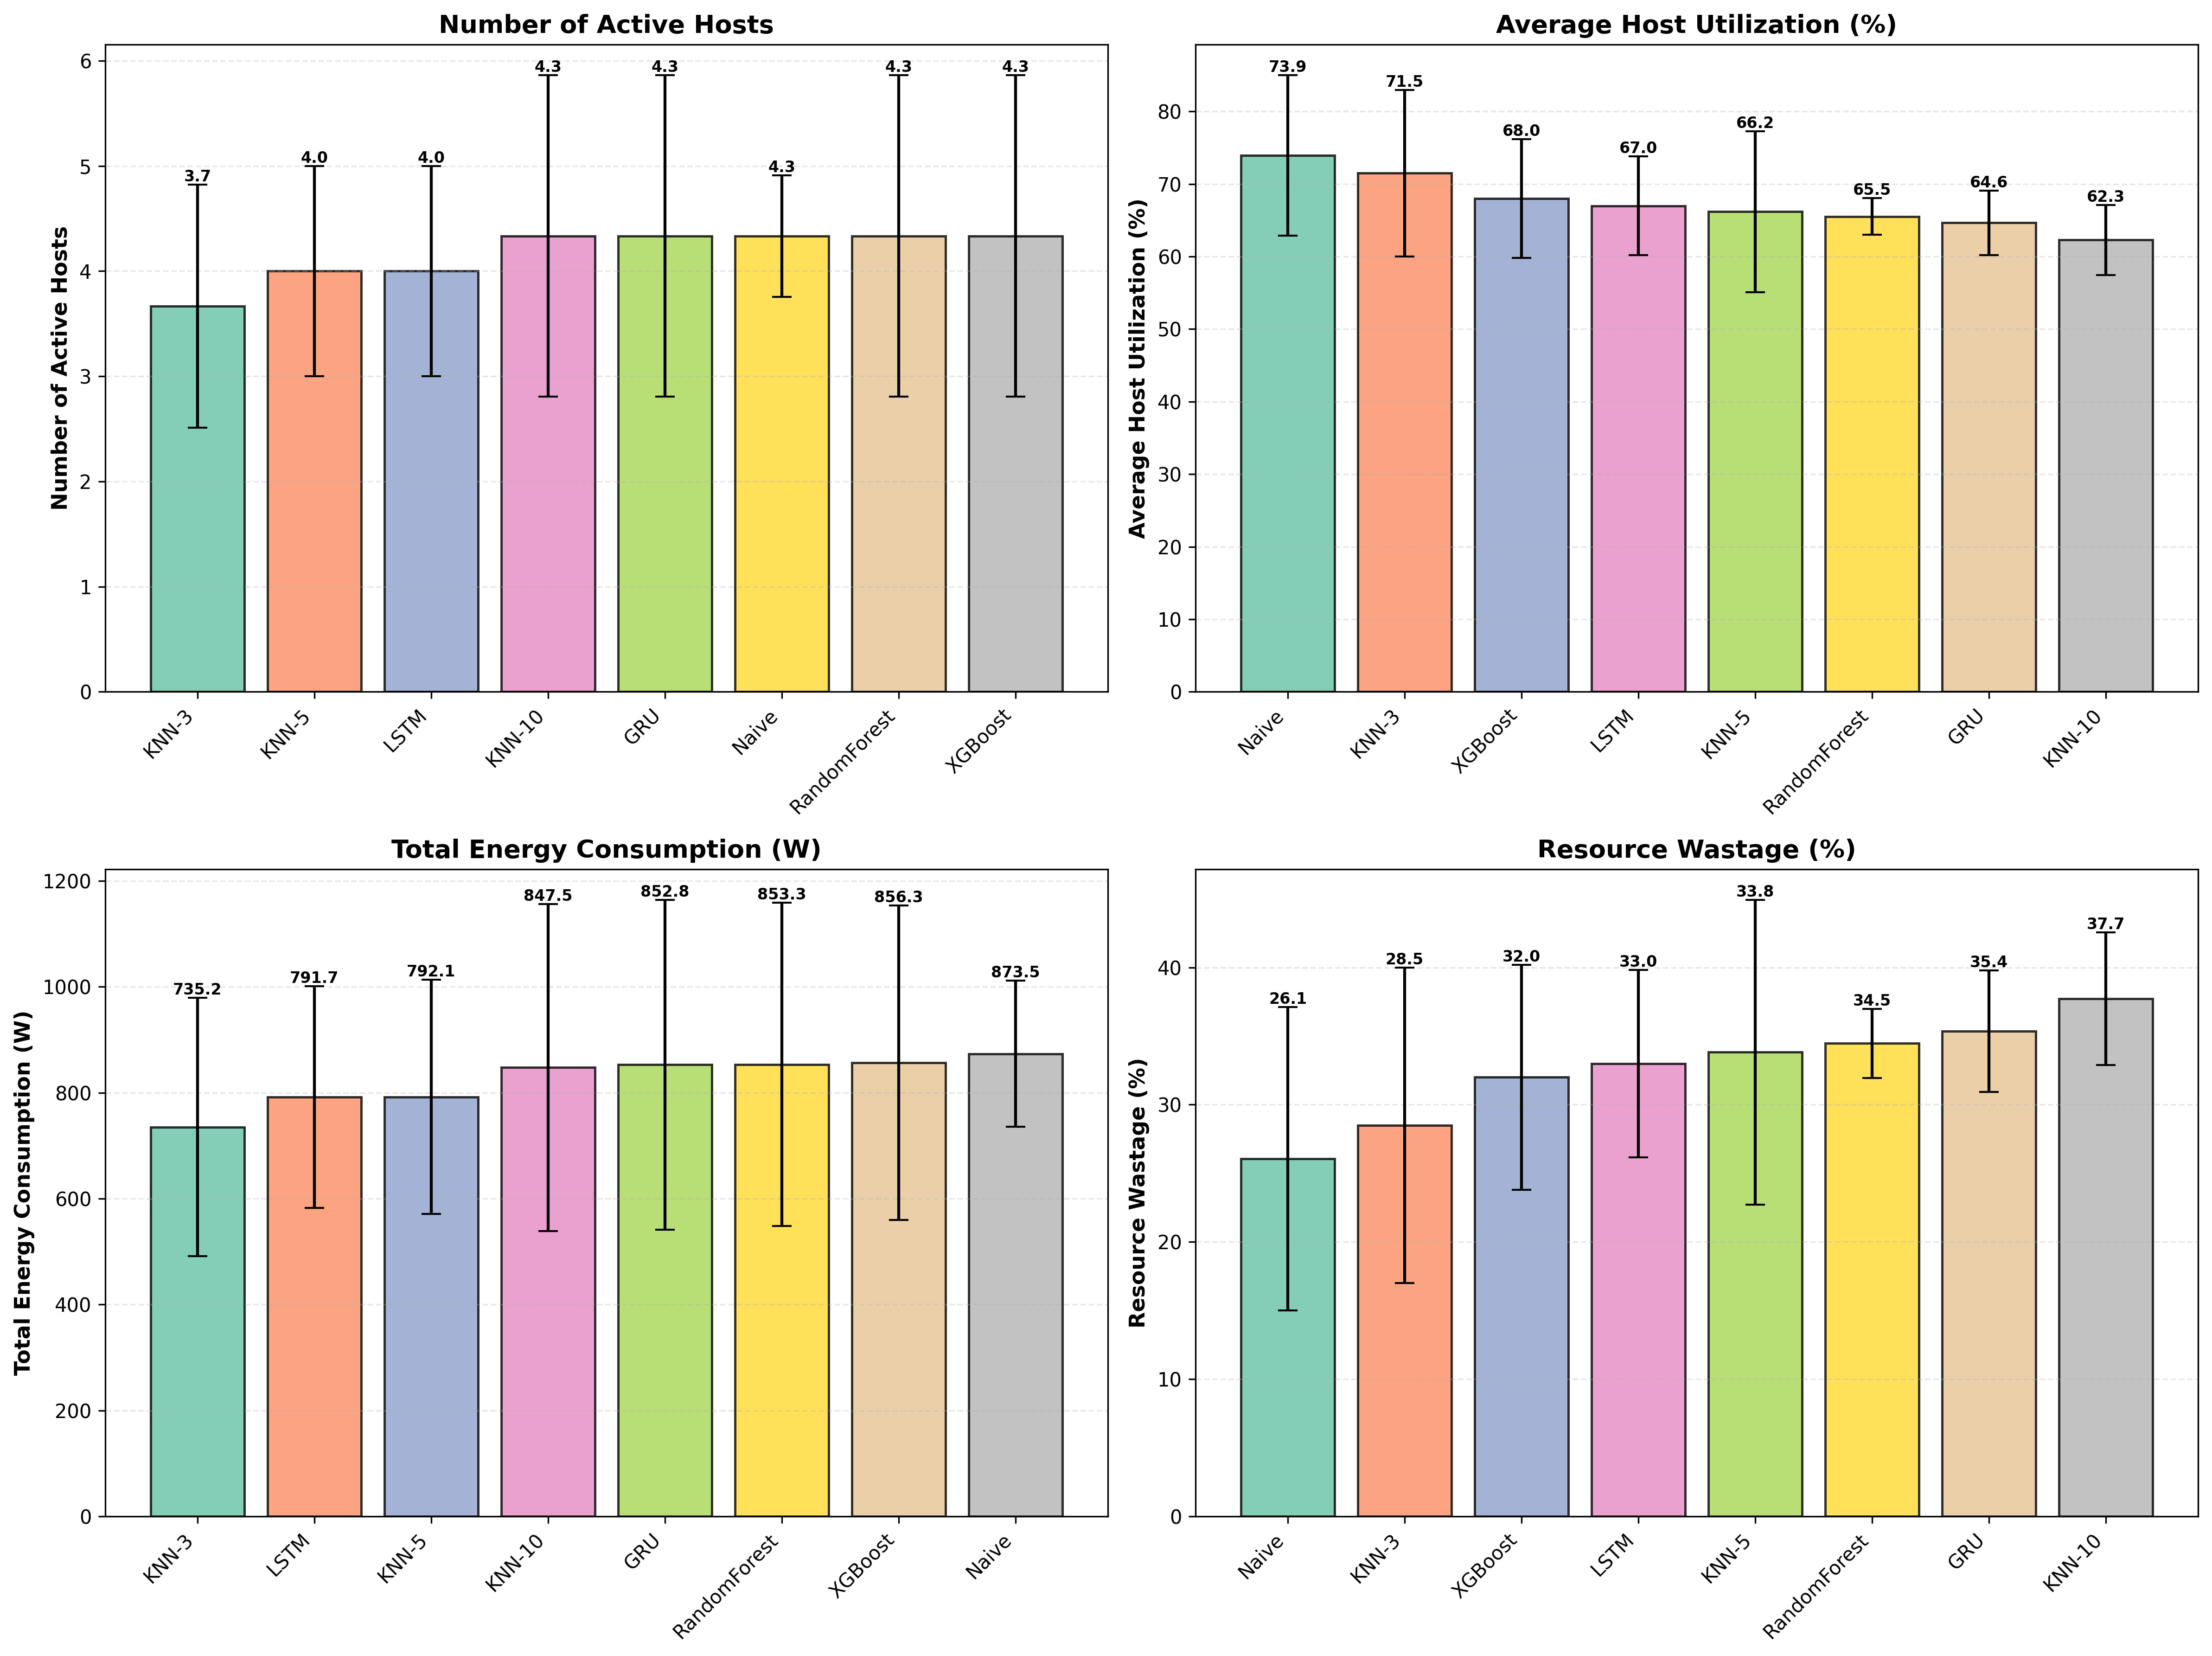

✓ Figure 4 saved: Figure4_Consolidation_Results.png



In [14]:
# ============================================================================
# CELL 12: Figure 4 - Consolidation Results Comparison
# ============================================================================

fig, axes = plt.subplots(2, 2, figsize=(16, 12), dpi=CONFIG['DPI'])

metrics_consol = [
    ('N_Hosts', 'Number of Active Hosts', False),
    ('Avg_Utilization', 'Average Host Utilization (%)', True),
    ('Total_Energy_W', 'Total Energy Consumption (W)', False),
    ('Resource_Wastage_%', 'Resource Wastage (%)', False)
]

colors = sns.color_palette("Set2", n_colors=len(consol_df['Model'].unique()))

for idx, (metric, title, higher_better) in enumerate(metrics_consol):
    ax = axes[idx // 2, idx % 2]
    
    # Prepare data
    plot_data = consol_df.pivot(index='Subset', columns='Model', values=metric)
    
    # Sort
    model_order = consol_df.groupby('Model')[metric].mean().sort_values(ascending=not higher_better).index
    plot_data = plot_data[model_order]
    
    means = plot_data.mean()
    stds = plot_data.std()
    
    x_pos = np.arange(len(means))
    bars = ax.bar(x_pos, means, yerr=stds, capsize=5, alpha=0.8,
                   color=colors[:len(means)], edgecolor='black', linewidth=1.2)
    
    ax.set_xticks(x_pos)
    ax.set_xticklabels(means.index, rotation=45, ha='right', fontsize=10)
    ax.set_ylabel(title, fontsize=11, fontweight='bold')
    ax.set_title(title, fontsize=13, fontweight='bold')
    ax.grid(axis='y', alpha=0.3, linestyle='--')
    
    # Value labels
    for bar, mean, std in zip(bars, means, stds):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + std,
                f'{mean:.1f}', ha='center', va='bottom', fontsize=8, fontweight='bold')

plt.tight_layout()
plt.savefig('Figure4_Consolidation_Results.png', dpi=CONFIG['DPI'], bbox_inches='tight')
plt.show()

print("✓ Figure 4 saved: Figure4_Consolidation_Results.png\n")

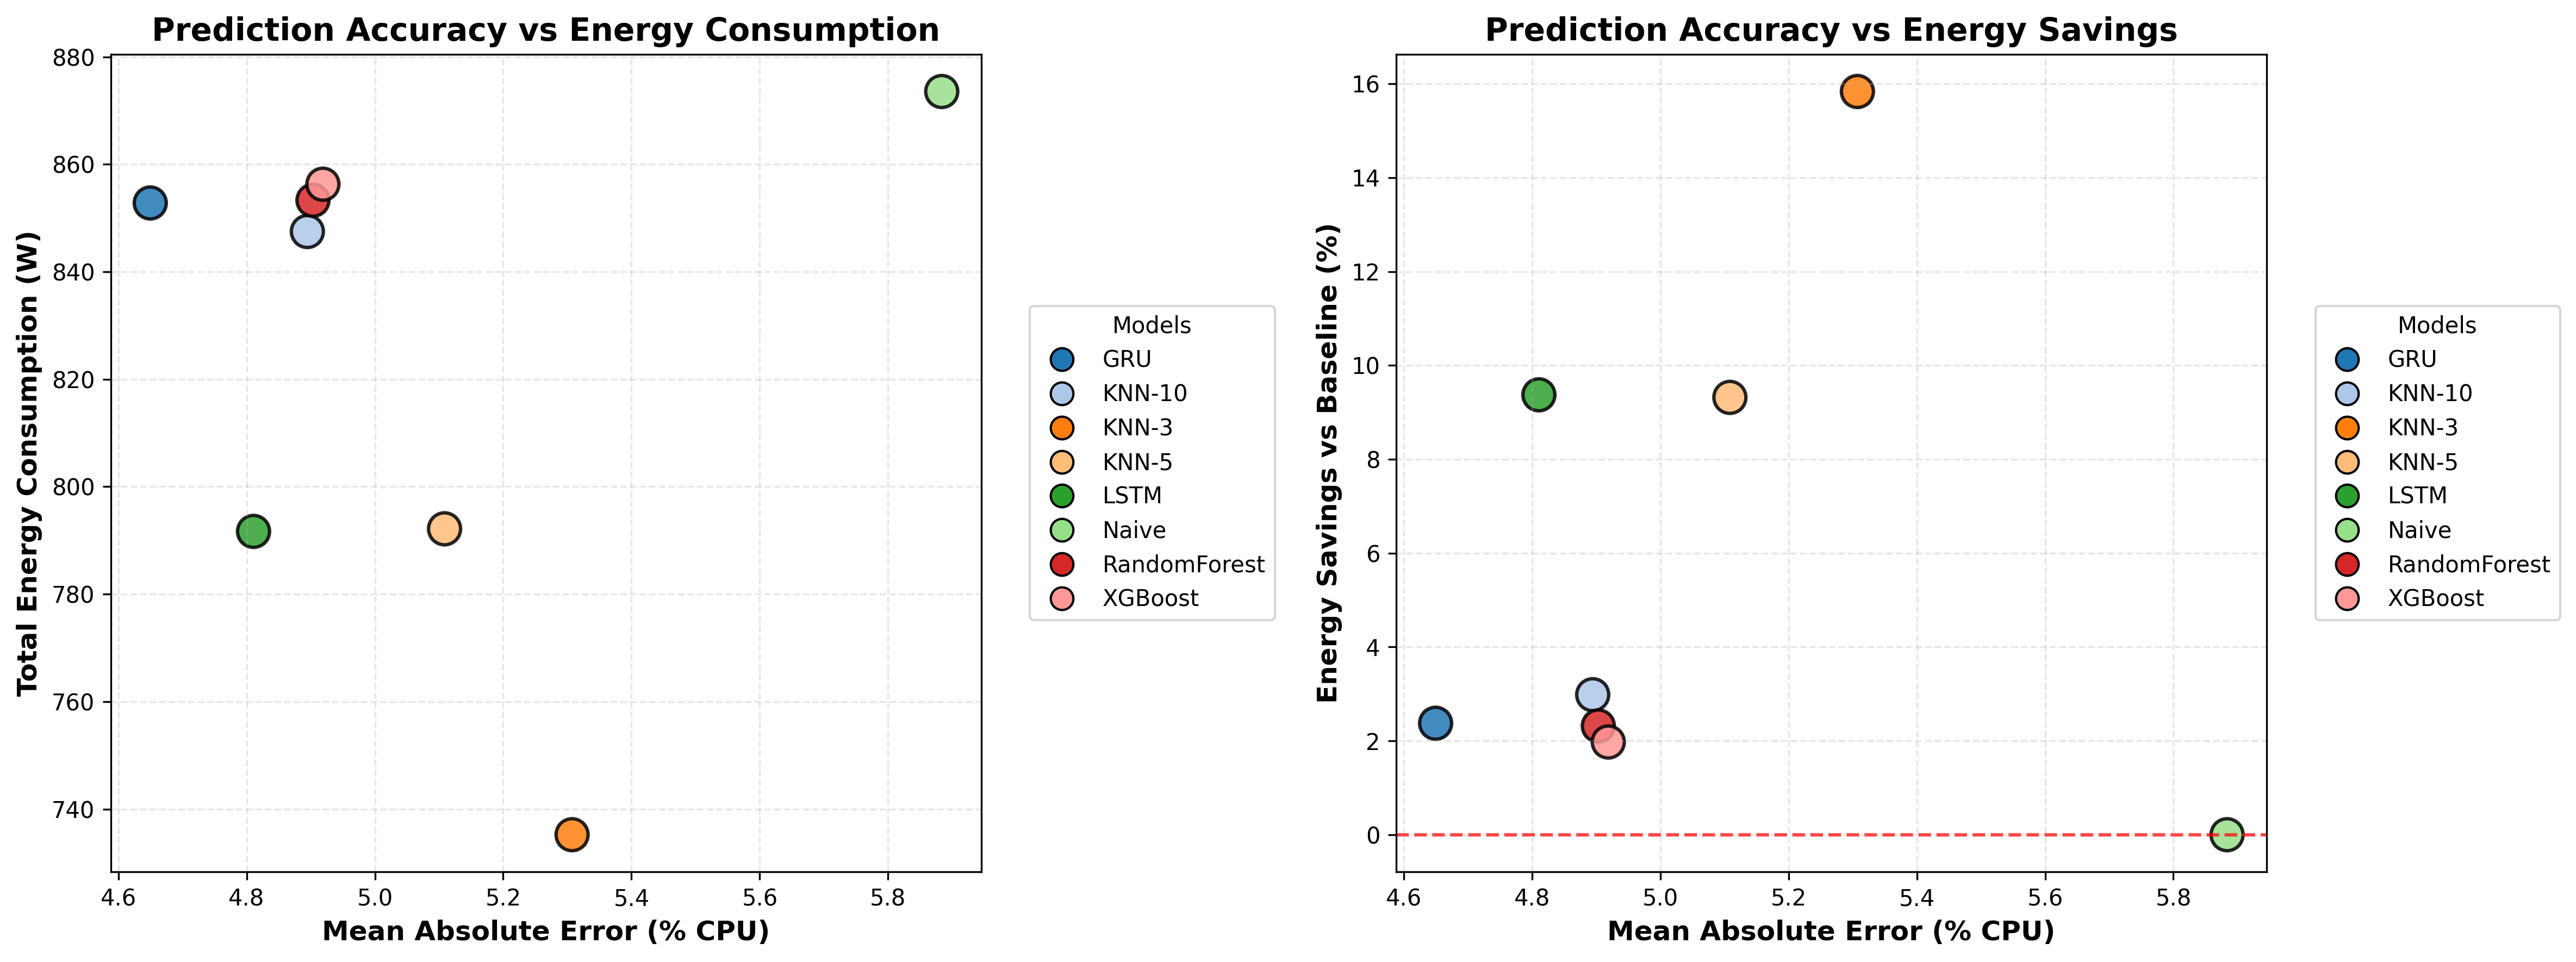

✓ Figure 5 saved: Figure5_Energy_vs_Accuracy.png



In [ ]:
# ============================================================================
# CELL 13: Figure 5 - Energy Savings vs Prediction Accuracy (Consistent Colors)
# ============================================================================

# Merge prediction MAE with consolidation energy
merged = results_df.groupby('Model')['MAE'].mean().reset_index()
merged = merged.merge(
    consol_df.groupby('Model')['Total_Energy_W'].mean().reset_index(),
    on='Model'
)
merged = merged.merge(energy_savings_df, on='Model')

# Create a consistent color map for all models
num_models = len(merged)
cmap = plt.cm.tab20  # High-quality distinct colors
colors = [cmap(i) for i in range(num_models)]

fig, axes = plt.subplots(1, 2, figsize=(16, 6), dpi=CONFIG['DPI'])

# ============================================================================
# LEFT: MAE vs Total Energy Consumption
# ============================================================================
ax = axes[0]
scatter = ax.scatter(
    merged['MAE'],
    merged['Total_Energy_W'],
    s=200,
    c=colors,         # <-- SAME COLORS
    alpha=0.85,
    edgecolors='black',
    linewidth=1.5
)

# ---- LEGEND (consistent colors → models) ----
handles = [
    plt.Line2D(
        [], [], marker='o', linestyle='None',
        markersize=10,
        markerfacecolor=colors[i],
        markeredgecolor='black',
        label=model
    )
    for i, model in enumerate(merged['Model'])
]
ax.legend(handles=handles, title="Models", loc='center right', bbox_to_anchor=(1.35, 0.5))

ax.set_xlabel('Mean Absolute Error (% CPU)', fontsize=12, fontweight='bold')
ax.set_ylabel('Total Energy Consumption (W)', fontsize=12, fontweight='bold')
ax.set_title('Prediction Accuracy vs Energy Consumption', fontsize=14, fontweight='bold')
ax.grid(alpha=0.3, linestyle='--')

# ============================================================================
# RIGHT: MAE vs Energy Savings
# ============================================================================
ax = axes[1]
scatter = ax.scatter(
    merged['MAE'],
    merged['Energy_Saving_%'],
    s=200,
    c=colors,         # <-- SAME COLORS AGAIN
    alpha=0.85,
    edgecolors='black',
    linewidth=1.5
)

# ---- LEGEND (same colors) ----
handles = [
    plt.Line2D(
        [], [], marker='o', linestyle='None',
        markersize=10,
        markerfacecolor=colors[i],
        markeredgecolor='black',
        label=model
    )
    for i, model in enumerate(merged['Model'])
]
ax.legend(handles=handles, title="Models", loc='center right', bbox_to_anchor=(1.35, 0.5))

ax.axhline(0, color='red', linestyle='--', linewidth=1.5, alpha=0.7, label='Baseline')

ax.set_xlabel('Mean Absolute Error (% CPU)', fontsize=12, fontweight='bold')
ax.set_ylabel('Energy Savings vs Baseline (%)', fontsize=12, fontweight='bold')
ax.set_title('Prediction Accuracy vs Energy Savings', fontsize=14, fontweight='bold')
ax.grid(alpha=0.3, linestyle='--')

plt.tight_layout()
plt.savefig('Figure5_Energy_vs_Accuracy.png', dpi=CONFIG['DPI'], bbox_inches='tight')
plt.show()

print("✓ Figure 5 saved: Figure5_Energy_vs_Accuracy.png\n")


In [18]:
# ============================================================================
# CELL 14: Final Summary Tables (LaTeX-ready for Paper)
# ============================================================================

print("="*80)
print("TABLE 1: PREDICTION PERFORMANCE (Mean ± Std)")
print("="*80)

table1 = results_df.groupby('Model').agg({
    'MAE': lambda x: f"{x.mean():.3f} ± {x.std():.3f}",
    'RMSE': lambda x: f"{x.mean():.3f} ± {x.std():.3f}",
    'R2': lambda x: f"{x.mean():.3f} ± {x.std():.3f}"
})

# Sort by MAE
mae_means = results_df.groupby('Model')['MAE'].mean()
table1 = table1.loc[mae_means.sort_values().index]

print(table1.to_string())
print("\n" + "="*80 + "\n")

# LaTeX export
with open('Table1_Prediction_Performance.tex', 'w') as f:
    f.write(table1.to_latex())

print("="*80)
print("TABLE 2: CONSOLIDATION PERFORMANCE (Mean ± Std)")
print("="*80)

table2 = consol_df.groupby('Model').agg({
    'N_Hosts': lambda x: f"{x.mean():.2f} ± {x.std():.2f}",
    'Avg_Utilization': lambda x: f"{x.mean():.2f} ± {x.std():.2f}",
    'Total_Energy_W': lambda x: f"{x.mean():.2f} ± {x.std():.2f}",
    'SLA_Violations': lambda x: f"{x.mean():.2f} ± {x.std():.2f}"
})

# Add energy savings
table2 = table2.merge(
    energy_savings_df.set_index('Model')[['Energy_Saving_%']],
    left_index=True,
    right_index=True
)
table2['Energy_Saving_%'] = table2['Energy_Saving_%'].apply(lambda x: f"{x:.2f}")

# Sort by energy
energy_means = consol_df.groupby('Model')['Total_Energy_W'].mean()
table2 = table2.loc[energy_means.sort_values().index]

print(table2.to_string())
print("\n" + "="*80 + "\n")

# LaTeX export
with open('Table2_Consolidation_Performance.tex', 'w') as f:
    f.write(table2.to_latex())

print("✓ Tables saved as LaTeX (.tex files)\n")

print("="*80)
print("FINAL PROJECT SUMMARY")
print("="*80)
print(f"Total VMs analyzed: {len(all_traces)}")
print(f"Subsets evaluated: {CONFIG['N_SUBSETS']}")
print(f"VMs per subset: {CONFIG['VMS_PER_SUBSET']}")
print(f"Models compared: {len(results_df['Model'].unique())}")
print(f"\nBest prediction model (MAE): {mae_means.idxmin()} ({mae_means.min():.3f}%)")
print(f"Best energy savings: {energy_savings_df.iloc[0]['Model']} ({energy_savings_df.iloc[0]['Energy_Saving_%']:.2f}%)")
print("="*80 + "\n")

print("✓✓✓ ALL ANALYSIS COMPLETE ✓✓✓")
print("\nGenerated files:")
print("  - prediction_results.csv")
print("  - prediction_summary.csv")
print("  - statistical_comparison.csv")
print("  - consolidation_results.csv")
print("  - consolidation_summary.csv")
print("  - energy_savings.csv")
print("  - Figure1_Prediction_Performance.png")
print("  - Figure2_Error_Distribution.png")
print("  - Figure3_Sample_Predictions.png")
print("  - Figure4_Consolidation_Results.png")
print("  - Figure5_Energy_vs_Accuracy.png")
print("  - Table1_Prediction_Performance.tex")
print("  - Table2_Consolidation_Performance.tex")

TABLE 1: PREDICTION PERFORMANCE (Mean ± Std)
                        MAE            RMSE             R2
Model                                                     
GRU           4.650 ± 0.648   8.924 ± 0.764  0.572 ± 0.247
LSTM          4.811 ± 0.832   9.075 ± 1.014  0.569 ± 0.228
KNN-10        4.895 ± 0.580   9.199 ± 0.660  0.540 ± 0.274
RandomForest  4.903 ± 0.639   9.134 ± 0.636  0.550 ± 0.259
XGBoost       4.919 ± 0.662   9.309 ± 0.647  0.535 ± 0.260
KNN-5         5.109 ± 0.605   9.558 ± 0.710  0.502 ± 0.302
KNN-3         5.307 ± 0.621   9.993 ± 0.730  0.454 ± 0.332
Naive         5.884 ± 0.790  12.007 ± 0.939  0.222 ± 0.451


TABLE 2: CONSOLIDATION PERFORMANCE (Mean ± Std)
                  N_Hosts Avg_Utilization   Total_Energy_W SLA_Violations Energy_Saving_%
Model                                                                                    
KNN-3         3.67 ± 1.15   71.50 ± 11.48  735.22 ± 244.12    0.00 ± 0.00           15.84
LSTM          4.00 ± 1.00    67.00 ± 6.82  79

# CELL 15: Hyperparameter Tuning (RandomizedSearchCV for KNN, RF, XGBoost)

In [19]:
# ============================================================================
# CELL 15: Hyperparameter Tuning with RandomizedSearchCV
# ============================================================================

from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
import time

print("="*80)
print("HYPERPARAMETER TUNING")
print("="*80)

# Use first subset for tuning
X_train_tune = datasets[0]['X_train']
y_train_tune = datasets[0]['y_train']
X_test_tune = datasets[0]['X_test']
y_test_tune = datasets[0]['y_test']

# TimeSeriesSplit for cross-validation
tscv = TimeSeriesSplit(n_splits=3)

tuning_results = []

# ============================================================================
# 1. KNN Hyperparameter Tuning
# ============================================================================
print("\n[1/3] Tuning KNN...")
knn_param_dist = {
    'n_neighbors': [3, 5, 7, 10, 15, 20],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

knn_search = RandomizedSearchCV(
    KNeighborsRegressor(),
    param_distributions=knn_param_dist,
    n_iter=10,
    cv=tscv,
    scoring='neg_mean_absolute_error',
    random_state=42,
    n_jobs=-1,
    verbose=0
)

start_time = time.time()
knn_search.fit(X_train_tune, y_train_tune)
knn_tune_time = time.time() - start_time

best_knn = knn_search.best_estimator_
y_pred_knn = best_knn.predict(X_test_tune)
knn_mae = mean_absolute_error(y_test_tune, y_pred_knn)

tuning_results.append({
    'Model': 'KNN',
    'Best_Params': str(knn_search.best_params_),
    'CV_MAE': -knn_search.best_score_,
    'Test_MAE': knn_mae,
    'Tuning_Time_s': knn_tune_time
})

print(f"  Best params: {knn_search.best_params_}")
print(f"  CV MAE: {-knn_search.best_score_:.4f}")
print(f"  Test MAE: {knn_mae:.4f}")
print(f"  Tuning time: {knn_tune_time:.2f}s")

# ============================================================================
# 2. Random Forest Hyperparameter Tuning
# ============================================================================
print("\n[2/3] Tuning Random Forest...")
rf_param_dist = {
    'n_estimators': [50, 100, 150],
    'max_depth': [10, 15, 20, None],
    'min_samples_split': [5, 10, 20],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

rf_search = RandomizedSearchCV(
    RandomForestRegressor(random_state=42, n_jobs=-1),
    param_distributions=rf_param_dist,
    n_iter=15,
    cv=tscv,
    scoring='neg_mean_absolute_error',
    random_state=42,
    n_jobs=-1,
    verbose=0
)

start_time = time.time()
rf_search.fit(X_train_tune, y_train_tune)
rf_tune_time = time.time() - start_time

best_rf = rf_search.best_estimator_
y_pred_rf = best_rf.predict(X_test_tune)
rf_mae = mean_absolute_error(y_test_tune, y_pred_rf)

tuning_results.append({
    'Model': 'RandomForest',
    'Best_Params': str(rf_search.best_params_),
    'CV_MAE': -rf_search.best_score_,
    'Test_MAE': rf_mae,
    'Tuning_Time_s': rf_tune_time
})

print(f"  Best params: {rf_search.best_params_}")
print(f"  CV MAE: {-rf_search.best_score_:.4f}")
print(f"  Test MAE: {rf_mae:.4f}")
print(f"  Tuning time: {rf_tune_time:.2f}s")

# ============================================================================
# 3. XGBoost Hyperparameter Tuning
# ============================================================================
if XGBOOST_AVAILABLE:
    print("\n[3/3] Tuning XGBoost...")
    xgb_param_dist = {
        'n_estimators': [50, 100, 150],
        'max_depth': [3, 5, 7, 10],
        'learning_rate': [0.01, 0.05, 0.1, 0.2],
        'subsample': [0.7, 0.8, 0.9, 1.0],
        'colsample_bytree': [0.7, 0.8, 0.9, 1.0]
    }
    
    xgb_search = RandomizedSearchCV(
        xgb.XGBRegressor(random_state=42, n_jobs=-1),
        param_distributions=xgb_param_dist,
        n_iter=15,
        cv=tscv,
        scoring='neg_mean_absolute_error',
        random_state=42,
        n_jobs=-1,
        verbose=0
    )
    
    start_time = time.time()
    xgb_search.fit(X_train_tune, y_train_tune)
    xgb_tune_time = time.time() - start_time
    
    best_xgb = xgb_search.best_estimator_
    y_pred_xgb = best_xgb.predict(X_test_tune)
    xgb_mae = mean_absolute_error(y_test_tune, y_pred_xgb)
    
    tuning_results.append({
        'Model': 'XGBoost',
        'Best_Params': str(xgb_search.best_params_),
        'CV_MAE': -xgb_search.best_score_,
        'Test_MAE': xgb_mae,
        'Tuning_Time_s': xgb_tune_time
    })
    
    print(f"  Best params: {xgb_search.best_params_}")
    print(f"  CV MAE: {-xgb_search.best_score_:.4f}")
    print(f"  Test MAE: {xgb_mae:.4f}")
    print(f"  Tuning time: {xgb_tune_time:.2f}s")

# Save results
tuning_df = pd.DataFrame(tuning_results)
print("\n" + "="*80)
print("HYPERPARAMETER TUNING SUMMARY")
print("="*80)
print(tuning_df.to_string(index=False))
print("="*80 + "\n")

tuning_df.to_csv('hyperparameter_tuning_results.csv', index=False)
print("✓ Tuning results saved to hyperparameter_tuning_results.csv\n")

# Store best models for later use
best_models = {
    'KNN_tuned': best_knn,
    'RF_tuned': best_rf
}
if XGBOOST_AVAILABLE:
    best_models['XGB_tuned'] = best_xgb

HYPERPARAMETER TUNING

[1/3] Tuning KNN...
  Best params: {'weights': 'distance', 'n_neighbors': 15, 'metric': 'manhattan'}
  CV MAE: 3.9993
  Test MAE: 4.1819
  Tuning time: 1.90s

[2/3] Tuning Random Forest...
  Best params: {'n_estimators': 150, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': None}
  CV MAE: 3.9721
  Test MAE: 4.2023
  Tuning time: 5.84s

[3/3] Tuning XGBoost...
  Best params: {'subsample': 0.8, 'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.1, 'colsample_bytree': 0.7}
  CV MAE: 4.1017
  Test MAE: 4.3156
  Tuning time: 4.23s

HYPERPARAMETER TUNING SUMMARY
       Model                                                                                                     Best_Params   CV_MAE  Test_MAE  Tuning_Time_s
         KNN                                               {'weights': 'distance', 'n_neighbors': 15, 'metric': 'manhattan'} 3.999291  4.181886       1.900366
RandomForest {'n_estimators': 150, 'min_samples_split': 

In [20]:
# ============================================================================
# CELL 16: LSTM/GRU Architecture Search
# ============================================================================

if DEEP_LEARNING_AVAILABLE:
    print("="*80)
    print("DEEP LEARNING ARCHITECTURE SEARCH")
    print("="*80)
    
    X_train_dl = datasets[0]['X_train']
    y_train_dl = datasets[0]['y_train']
    X_test_dl = datasets[0]['X_test']
    y_test_dl = datasets[0]['y_test']
    
    # Reshape for LSTM/GRU
    X_train_dl_reshaped = X_train_dl.reshape((X_train_dl.shape[0], X_train_dl.shape[1], 1))
    X_test_dl_reshaped = X_test_dl.reshape((X_test_dl.shape[0], X_test_dl.shape[1], 1))
    
    # Define architectures to try
    architectures = [
        {'name': 'LSTM_small', 'type': 'LSTM', 'units': [32, 32], 'dropout': 0.2},
        {'name': 'LSTM_medium', 'type': 'LSTM', 'units': [50, 50], 'dropout': 0.2},
        {'name': 'LSTM_large', 'type': 'LSTM', 'units': [64, 64], 'dropout': 0.3},
        {'name': 'GRU_small', 'type': 'GRU', 'units': [32, 32], 'dropout': 0.2},
        {'name': 'GRU_medium', 'type': 'GRU', 'units': [50, 50], 'dropout': 0.2},
        {'name': 'GRU_large', 'type': 'GRU', 'units': [64, 64], 'dropout': 0.3},
    ]
    
    dl_results = []
    
    for arch in architectures:
        print(f"\nTraining {arch['name']}...")
        
        model = Sequential()
        
        # First layer
        if arch['type'] == 'LSTM':
            model.add(LSTM(arch['units'][0], activation='relu', return_sequences=True,
                          input_shape=(X_train_dl.shape[1], 1)))
        else:
            model.add(GRU(arch['units'][0], activation='relu', return_sequences=True,
                         input_shape=(X_train_dl.shape[1], 1)))
        
        model.add(Dropout(arch['dropout']))
        
        # Second layer
        if arch['type'] == 'LSTM':
            model.add(LSTM(arch['units'][1], activation='relu'))
        else:
            model.add(GRU(arch['units'][1], activation='relu'))
        
        model.add(Dropout(arch['dropout']))
        model.add(Dense(1))
        
        model.compile(optimizer='adam', loss='mse', metrics=['mae'])
        
        early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
        
        start_time = time.time()
        history = model.fit(
            X_train_dl_reshaped, y_train_dl,
            validation_data=(X_test_dl_reshaped, y_test_dl),
            epochs=50,
            batch_size=64,
            callbacks=[early_stop],
            verbose=0
        )
        train_time = time.time() - start_time
        
        # Evaluate
        y_pred = model.predict(X_test_dl_reshaped, verbose=0).flatten()
        test_mae = mean_absolute_error(y_test_dl, y_pred)
        test_rmse = np.sqrt(mean_squared_error(y_test_dl, y_pred))
        
        dl_results.append({
            'Architecture': arch['name'],
            'Type': arch['type'],
            'Units': str(arch['units']),
            'Dropout': arch['dropout'],
            'Train_MAE': history.history['mae'][-1],
            'Val_MAE': history.history['val_mae'][-1],
            'Test_MAE': test_mae,
            'Test_RMSE': test_rmse,
            'Epochs': len(history.history['loss']),
            'Train_Time_s': train_time
        })
        
        print(f"  Val MAE: {history.history['val_mae'][-1]:.4f}, Test MAE: {test_mae:.4f}")
    
    dl_results_df = pd.DataFrame(dl_results)
    
    print("\n" + "="*80)
    print("DEEP LEARNING ARCHITECTURE SEARCH RESULTS")
    print("="*80)
    print(dl_results_df.to_string(index=False))
    print("="*80 + "\n")
    
    # Find best architectures
    best_lstm = dl_results_df[dl_results_df['Type'] == 'LSTM'].sort_values('Test_MAE').iloc[0]
    best_gru = dl_results_df[dl_results_df['Type'] == 'GRU'].sort_values('Test_MAE').iloc[0]
    
    print(f"Best LSTM: {best_lstm['Architecture']} (Test MAE: {best_lstm['Test_MAE']:.4f})")
    print(f"Best GRU: {best_gru['Architecture']} (Test MAE: {best_gru['Test_MAE']:.4f})")
    
    dl_results_df.to_csv('deep_learning_architecture_search.csv', index=False)
    print("\n✓ DL architecture search results saved\n")
else:
    print("TensorFlow not available - skipping DL architecture search\n")

DEEP LEARNING ARCHITECTURE SEARCH

Training LSTM_small...
  Val MAE: 4.1337, Test MAE: 4.1311

Training LSTM_medium...
  Val MAE: 4.1076, Test MAE: 4.1049

Training LSTM_large...
  Val MAE: 4.1016, Test MAE: 4.1783

Training GRU_small...
  Val MAE: 4.1134, Test MAE: 4.1083

Training GRU_medium...
  Val MAE: 4.0970, Test MAE: 4.0670

Training GRU_large...
  Val MAE: 4.1047, Test MAE: 4.1363

DEEP LEARNING ARCHITECTURE SEARCH RESULTS
Architecture Type    Units  Dropout  Train_MAE  Val_MAE  Test_MAE  Test_RMSE  Epochs  Train_Time_s
  LSTM_small LSTM [32, 32]      0.2   4.204739 4.133700  4.131101   8.242557      25     19.271899
 LSTM_medium LSTM [50, 50]      0.2   4.210611 4.107598  4.104950   8.128655      18     16.650873
  LSTM_large LSTM [64, 64]      0.3   4.238215 4.101607  4.178284   8.178966      25     20.096531
   GRU_small  GRU [32, 32]      0.2   4.173735 4.113419  4.108287   8.145826      19     17.567575
  GRU_medium  GRU [50, 50]      0.2   4.154203 4.096973  4.067029   8

In [21]:
# ============================================================================
# CELL 17: k-Fold Cross-Validation (TimeSeriesSplit)
# ============================================================================

from sklearn.model_selection import cross_val_score

print("="*80)
print("K-FOLD CROSS-VALIDATION (TimeSeriesSplit)")
print("="*80)

X_train_cv = datasets[0]['X_train']
y_train_cv = datasets[0]['y_train']

tscv = TimeSeriesSplit(n_splits=5)

cv_results = []

# Models to evaluate
cv_models = {
    'KNN-10': KNeighborsRegressor(n_neighbors=10, weights='distance'),
    'KNN_tuned': best_models['KNN_tuned'],
    'RandomForest': RandomForestRegressor(n_estimators=100, max_depth=15, random_state=42, n_jobs=-1),
    'RF_tuned': best_models['RF_tuned']
}

if XGBOOST_AVAILABLE:
    cv_models['XGBoost'] = xgb.XGBRegressor(n_estimators=100, max_depth=6, random_state=42, n_jobs=-1)
    cv_models['XGB_tuned'] = best_models['XGB_tuned']

for model_name, model in cv_models.items():
    print(f"\nEvaluating {model_name} with 5-fold TimeSeriesSplit...")
    
    # Cross-validation scores (negative MAE)
    cv_scores = cross_val_score(
        model, X_train_cv, y_train_cv,
        cv=tscv,
        scoring='neg_mean_absolute_error',
        n_jobs=-1
    )
    
    # Convert to positive MAE
    cv_mae = -cv_scores
    
    cv_results.append({
        'Model': model_name,
        'CV_MAE_mean': cv_mae.mean(),
        'CV_MAE_std': cv_mae.std(),
        'CV_MAE_min': cv_mae.min(),
        'CV_MAE_max': cv_mae.max()
    })
    
    print(f"  CV MAE: {cv_mae.mean():.4f} ± {cv_mae.std():.4f}")

cv_results_df = pd.DataFrame(cv_results).sort_values('CV_MAE_mean')

print("\n" + "="*80)
print("CROSS-VALIDATION SUMMARY")
print("="*80)
print(cv_results_df.to_string(index=False))
print("="*80 + "\n")

cv_results_df.to_csv('cross_validation_results.csv', index=False)
print("✓ Cross-validation results saved\n")

K-FOLD CROSS-VALIDATION (TimeSeriesSplit)

Evaluating KNN-10 with 5-fold TimeSeriesSplit...
  CV MAE: 5.7432 ± 2.5195

Evaluating KNN_tuned with 5-fold TimeSeriesSplit...
  CV MAE: 5.5262 ± 2.5852

Evaluating RandomForest with 5-fold TimeSeriesSplit...
  CV MAE: 5.5738 ± 2.1047

Evaluating RF_tuned with 5-fold TimeSeriesSplit...
  CV MAE: 5.3134 ± 2.3696

Evaluating XGBoost with 5-fold TimeSeriesSplit...
  CV MAE: 6.1404 ± 2.5422

Evaluating XGB_tuned with 5-fold TimeSeriesSplit...
  CV MAE: 5.4052 ± 2.3098

CROSS-VALIDATION SUMMARY
       Model  CV_MAE_mean  CV_MAE_std  CV_MAE_min  CV_MAE_max
    RF_tuned     5.313371    2.369564    3.599928    9.838238
   XGB_tuned     5.405204    2.309776    3.673607    9.840107
   KNN_tuned     5.526214    2.585176    3.701335   10.589330
RandomForest     5.573816    2.104707    3.994019    9.559663
      KNN-10     5.743179    2.519471    3.916865   10.622021
     XGBoost     6.140395    2.542170    4.109222   10.976584

✓ Cross-validation results

FEATURE IMPORTANCE ANALYSIS


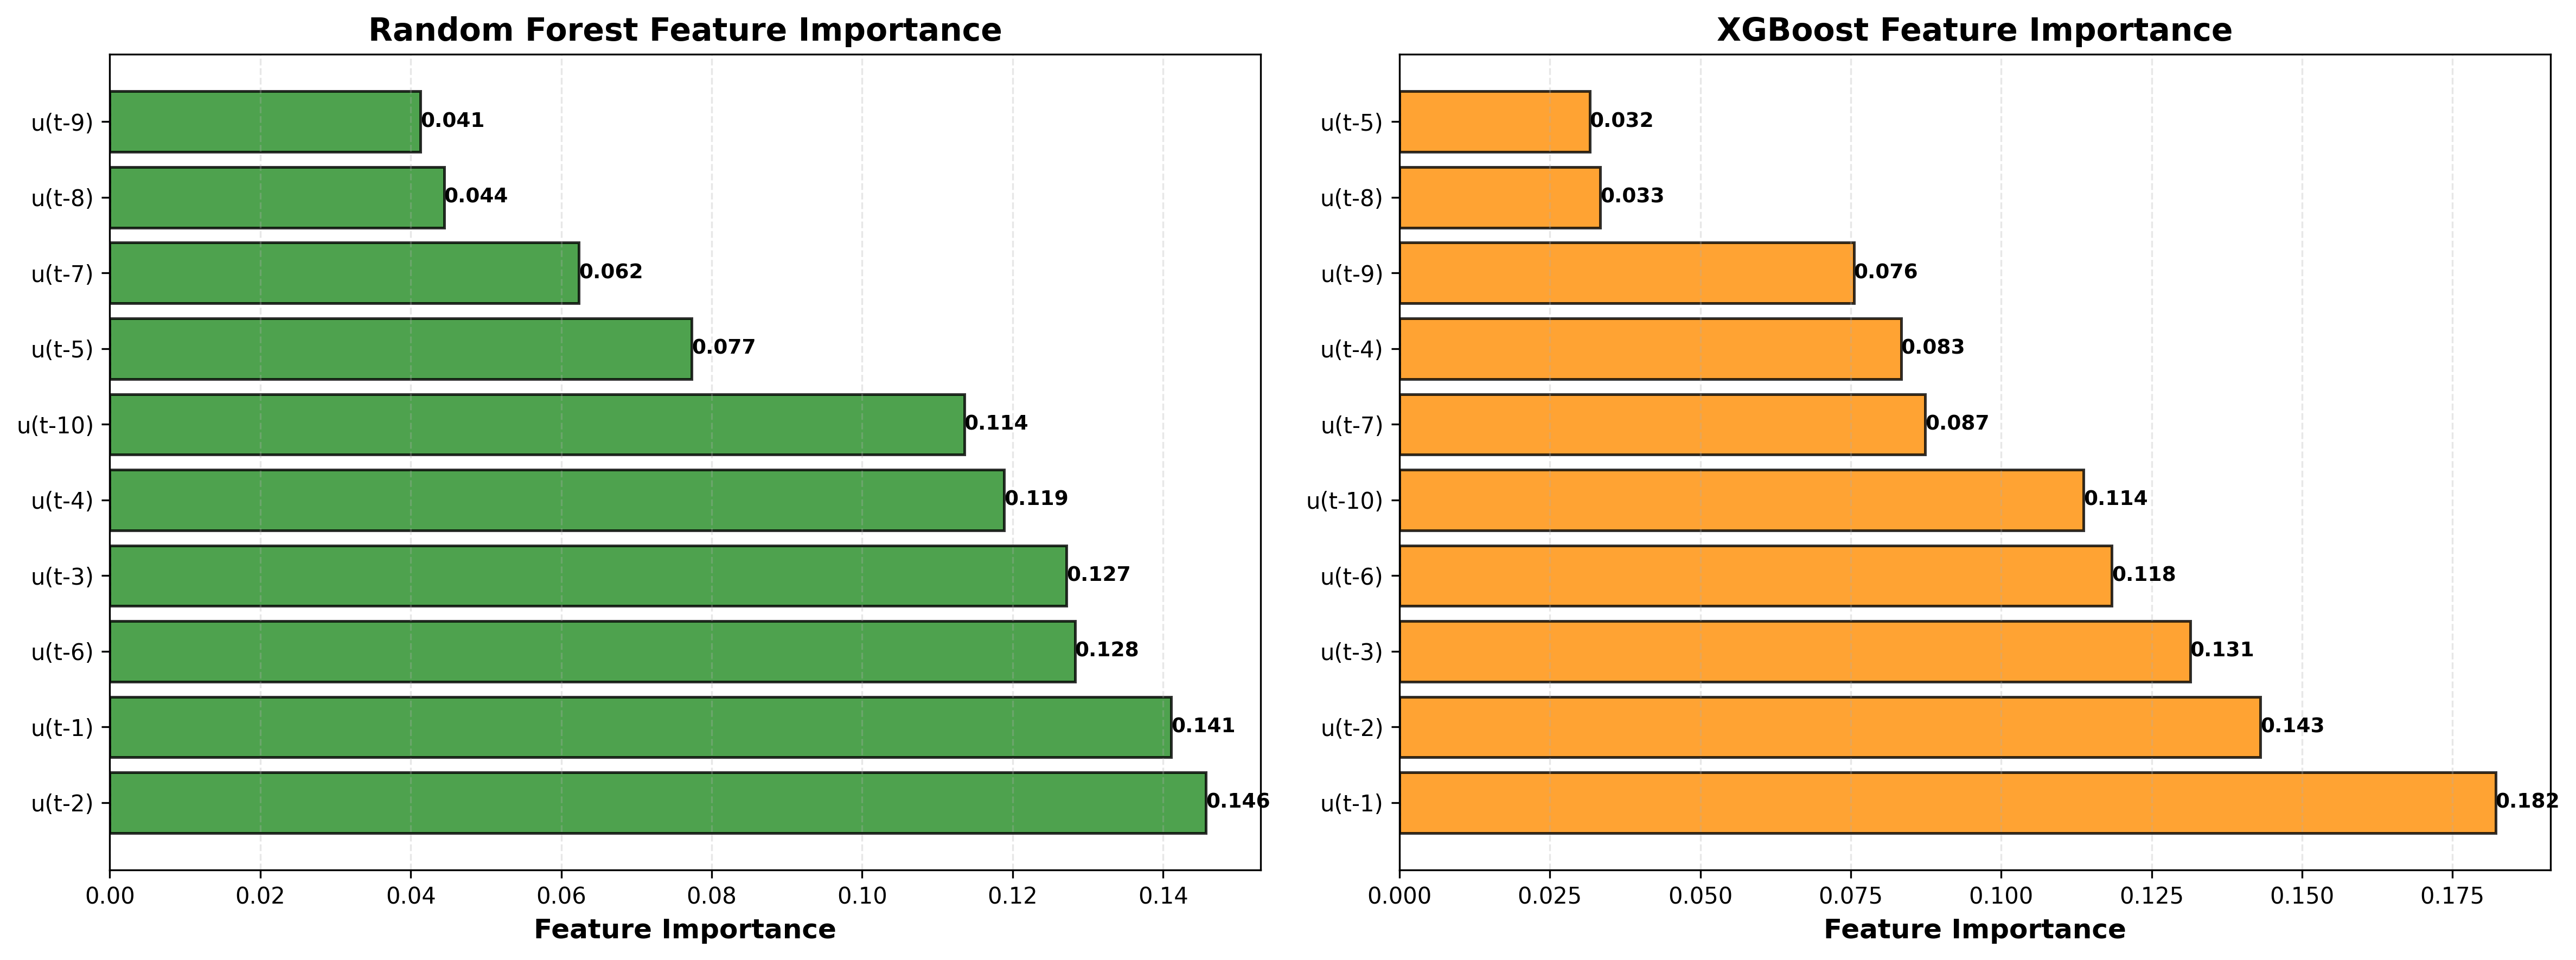


Feature Importance Rankings:
Feature  RF_Importance  XGB_Importance
 u(t-2)       0.145693        0.143096
 u(t-1)       0.141065        0.182160
 u(t-6)       0.128265        0.118389
 u(t-3)       0.127154        0.131406
 u(t-4)       0.118884        0.083365
u(t-10)       0.113566        0.113668
 u(t-5)       0.077326        0.031613
 u(t-7)       0.062336        0.087384
 u(t-8)       0.044417        0.033409
 u(t-9)       0.041294        0.075510

✓ Figure 6 saved: Figure6_Feature_Importance.png
✓ Feature importance saved to CSV



In [22]:
# ============================================================================
# CELL 18: Feature Importance Analysis (RF & XGBoost)
# ============================================================================

print("="*80)
print("FEATURE IMPORTANCE ANALYSIS")
print("="*80)

# Feature names (lag features)
feature_names = [f'u(t-{CONFIG["HISTORY_WINDOW"]-i})' for i in range(CONFIG['HISTORY_WINDOW'])]

fig, axes = plt.subplots(1, 2 if XGBOOST_AVAILABLE else 1, 
                         figsize=(16 if XGBOOST_AVAILABLE else 10, 6), 
                         dpi=CONFIG['DPI'])

if not XGBOOST_AVAILABLE:
    axes = [axes]

# Random Forest Feature Importance
ax = axes[0]
rf_importance = best_models['RF_tuned'].feature_importances_
sorted_idx = np.argsort(rf_importance)[::-1]

bars = ax.barh(range(len(rf_importance)), rf_importance[sorted_idx], 
               color='forestgreen', alpha=0.8, edgecolor='black', linewidth=1.2)
ax.set_yticks(range(len(rf_importance)))
ax.set_yticklabels([feature_names[i] for i in sorted_idx], fontsize=10)
ax.set_xlabel('Feature Importance', fontsize=12, fontweight='bold')
ax.set_title('Random Forest Feature Importance', fontsize=14, fontweight='bold')
ax.grid(axis='x', alpha=0.3, linestyle='--')

# Add value labels
for i, (bar, val) in enumerate(zip(bars, rf_importance[sorted_idx])):
    ax.text(val, bar.get_y() + bar.get_height()/2, f'{val:.3f}',
            ha='left', va='center', fontsize=9, fontweight='bold')

# XGBoost Feature Importance
if XGBOOST_AVAILABLE:
    ax = axes[1]
    xgb_importance = best_models['XGB_tuned'].feature_importances_
    sorted_idx_xgb = np.argsort(xgb_importance)[::-1]
    
    bars = ax.barh(range(len(xgb_importance)), xgb_importance[sorted_idx_xgb],
                   color='darkorange', alpha=0.8, edgecolor='black', linewidth=1.2)
    ax.set_yticks(range(len(xgb_importance)))
    ax.set_yticklabels([feature_names[i] for i in sorted_idx_xgb], fontsize=10)
    ax.set_xlabel('Feature Importance', fontsize=12, fontweight='bold')
    ax.set_title('XGBoost Feature Importance', fontsize=14, fontweight='bold')
    ax.grid(axis='x', alpha=0.3, linestyle='--')
    
    for i, (bar, val) in enumerate(zip(bars, xgb_importance[sorted_idx_xgb])):
        ax.text(val, bar.get_y() + bar.get_height()/2, f'{val:.3f}',
                ha='left', va='center', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.savefig('Figure6_Feature_Importance.png', dpi=CONFIG['DPI'], bbox_inches='tight')
plt.show()

# Save importance values
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'RF_Importance': rf_importance
})

if XGBOOST_AVAILABLE:
    importance_df['XGB_Importance'] = xgb_importance

importance_df = importance_df.sort_values('RF_Importance', ascending=False)

print("\nFeature Importance Rankings:")
print(importance_df.to_string(index=False))

importance_df.to_csv('feature_importance.csv', index=False)
print("\n✓ Figure 6 saved: Figure6_Feature_Importance.png")
print("✓ Feature importance saved to CSV\n")

SENSITIVITY ANALYSIS: OVERLOAD_THRESHOLD

Testing threshold = 70%...

Testing threshold = 75%...

Testing threshold = 80%...

Testing threshold = 85%...

Testing threshold = 90%...

SENSITIVITY ANALYSIS RESULTS
   Model  Threshold  N_Hosts  Avg_Utilization  Total_Energy_W  SLA_Violations  Resource_Wastage_%
   Naive         70        4        62.000000       779.44000               0           38.000000
RF_tuned         70        4        62.055099       779.55681               0           37.944901
   Naive         75        4        62.000000       779.44000               0           38.000000
RF_tuned         75        4        62.055099       779.55681               0           37.944901
   Naive         80        4        62.000000       779.44000               0           38.000000
RF_tuned         80        4        62.055099       779.55681               0           37.944901
   Naive         85        3        82.666667       617.44000               0           17.333333
RF_tu

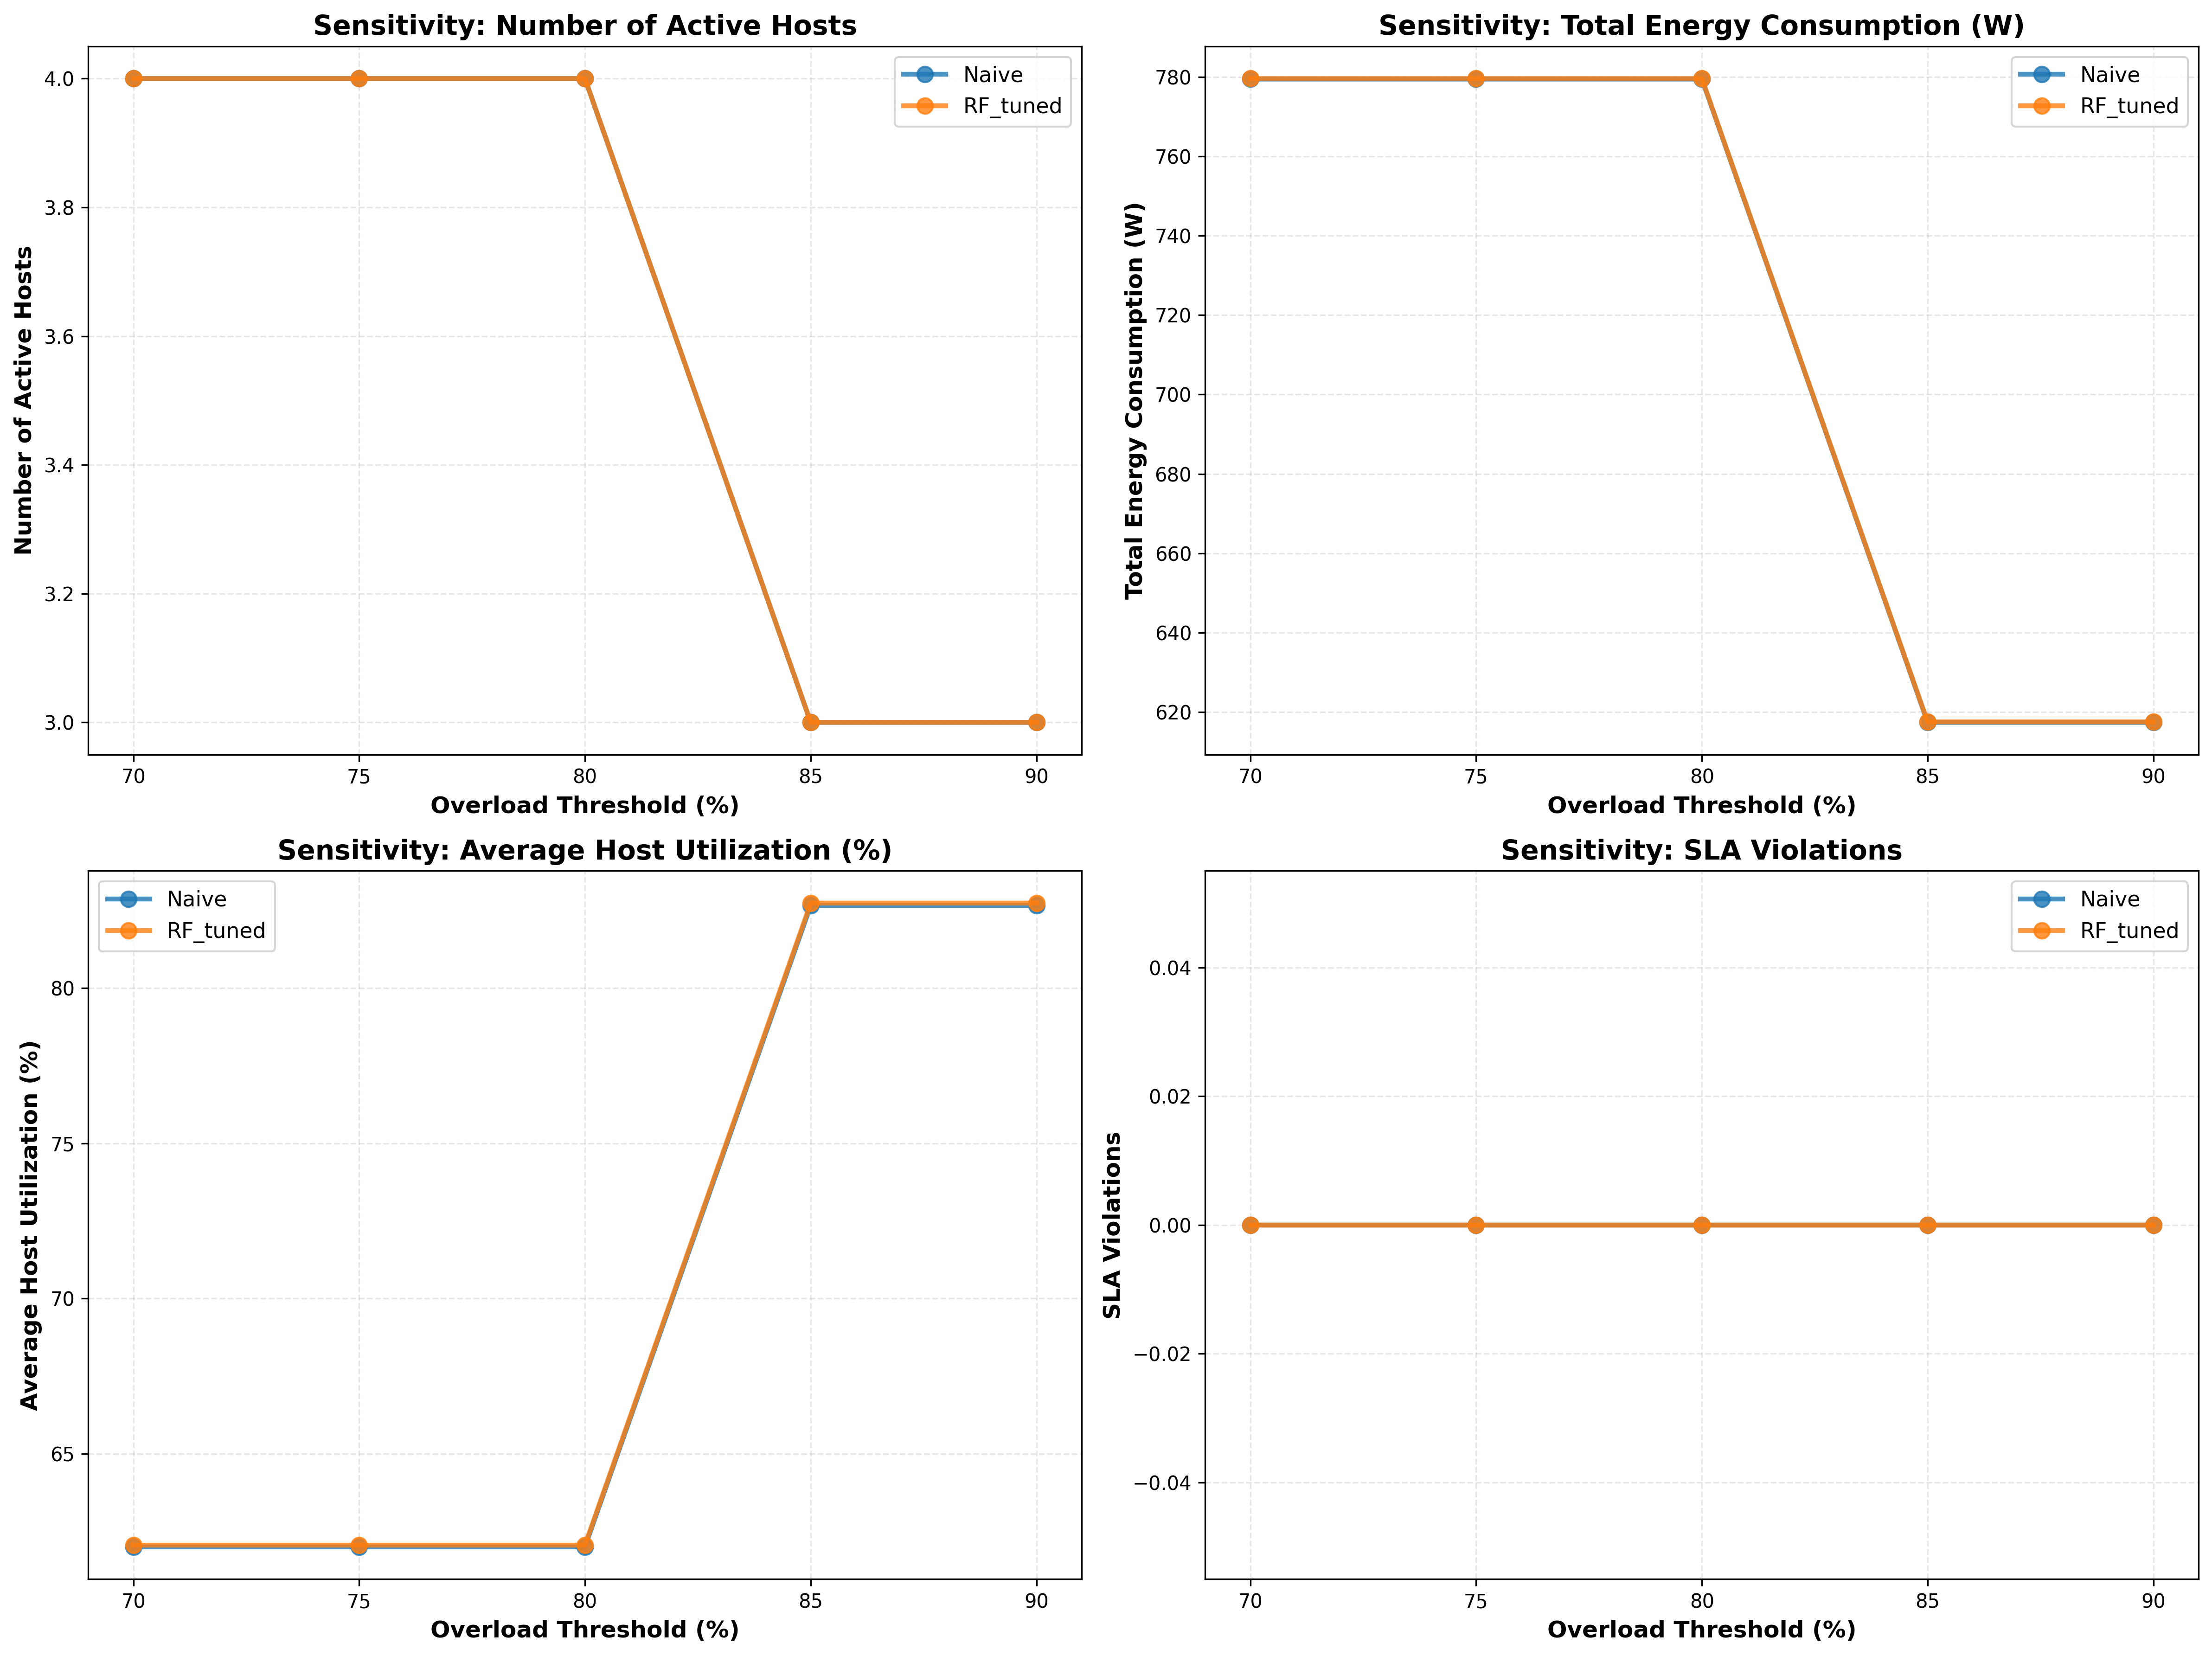

✓ Figure 7 saved: Figure7_Sensitivity_Analysis.png
✓ Sensitivity analysis saved to CSV



In [23]:
# ============================================================================
# CELL 19: Sensitivity Analysis - OVERLOAD_THRESHOLD
# ============================================================================

print("="*80)
print("SENSITIVITY ANALYSIS: OVERLOAD_THRESHOLD")
print("="*80)

# Test different thresholds
thresholds = [70, 75, 80, 85, 90]

# Use predictions from Naive and best tuned RF
sensitivity_results = []

# Get VM predictions for first subset
traces_sens = datasets[0]['traces']

# Naive predictions
naive_predictions = {}
for vm_id, trace in traces_sens.items():
    if len(trace) >= CONFIG['HISTORY_WINDOW'] + 1:
        naive_predictions[vm_id] = trace[-1]  # Last value

# RF tuned predictions
rf_predictions = {}
for vm_id, trace in traces_sens.items():
    if len(trace) >= CONFIG['HISTORY_WINDOW'] + 1:
        X_last = trace[-CONFIG['HISTORY_WINDOW']:].reshape(1, -1)
        pred = best_models['RF_tuned'].predict(X_last)[0]
        rf_predictions[vm_id] = max(0, min(100, pred))

# Test each threshold
for threshold in thresholds:
    print(f"\nTesting threshold = {threshold}%...")
    
    # Naive consolidation
    naive_result = consolidate_vms(
        naive_predictions,
        host_capacity=CONFIG['HOST_CAPACITY'],
        overload_threshold=threshold
    )
    
    sensitivity_results.append({
        'Model': 'Naive',
        'Threshold': threshold,
        'N_Hosts': naive_result['n_hosts'],
        'Avg_Utilization': naive_result['avg_utilization'],
        'Total_Energy_W': naive_result['total_energy'],
        'SLA_Violations': naive_result['sla_violations'],
        'Resource_Wastage_%': naive_result['resource_wastage']
    })
    
    # RF tuned consolidation
    rf_result = consolidate_vms(
        rf_predictions,
        host_capacity=CONFIG['HOST_CAPACITY'],
        overload_threshold=threshold
    )
    
    sensitivity_results.append({
        'Model': 'RF_tuned',
        'Threshold': threshold,
        'N_Hosts': rf_result['n_hosts'],
        'Avg_Utilization': rf_result['avg_utilization'],
        'Total_Energy_W': rf_result['total_energy'],
        'SLA_Violations': rf_result['sla_violations'],
        'Resource_Wastage_%': rf_result['resource_wastage']
    })

sensitivity_df = pd.DataFrame(sensitivity_results)

print("\n" + "="*80)
print("SENSITIVITY ANALYSIS RESULTS")
print("="*80)
print(sensitivity_df.to_string(index=False))
print("="*80 + "\n")

# Plot sensitivity
fig, axes = plt.subplots(2, 2, figsize=(16, 12), dpi=CONFIG['DPI'])

metrics_sens = [
    ('N_Hosts', 'Number of Active Hosts'),
    ('Total_Energy_W', 'Total Energy Consumption (W)'),
    ('Avg_Utilization', 'Average Host Utilization (%)'),
    ('SLA_Violations', 'SLA Violations')
]

for idx, (metric, title) in enumerate(metrics_sens):
    ax = axes[idx // 2, idx % 2]
    
    for model in ['Naive', 'RF_tuned']:
        model_data = sensitivity_df[sensitivity_df['Model'] == model]
        ax.plot(model_data['Threshold'], model_data[metric], 
                marker='o', linewidth=2.5, markersize=8, 
                label=model, alpha=0.8)
    
    ax.set_xlabel('Overload Threshold (%)', fontsize=12, fontweight='bold')
    ax.set_ylabel(title, fontsize=12, fontweight='bold')
    ax.set_title(f'Sensitivity: {title}', fontsize=14, fontweight='bold')
    ax.legend(fontsize=11, loc='best')
    ax.grid(alpha=0.3, linestyle='--')
    ax.set_xticks(thresholds)

plt.tight_layout()
plt.savefig('Figure7_Sensitivity_Analysis.png', dpi=CONFIG['DPI'], bbox_inches='tight')
plt.show()

sensitivity_df.to_csv('sensitivity_analysis.csv', index=False)
print("✓ Figure 7 saved: Figure7_Sensitivity_Analysis.png")
print("✓ Sensitivity analysis saved to CSV\n")

CONSOLIDATION ALGORITHM COMPARISON

Testing First Fit (FF)...
  Hosts: 4, Energy: 779.56W

Testing Best Fit (BF)...
  Hosts: 4, Energy: 779.56W

Testing Best Fit Decreasing (BFD)...
  Hosts: 4, Energy: 779.56W

Testing First Fit Decreasing (FFD)...
  Hosts: 4, Energy: 779.56W

ALGORITHM COMPARISON RESULTS
                 Algorithm  N_Hosts  Avg_Utilization  Total_Energy_W  SLA_Violations
            First Fit (FF)        4        62.055099       779.55681               0
             Best Fit (BF)        4        62.055099       779.55681               0
 Best Fit Decreasing (BFD)        4        62.055099       779.55681               0
First Fit Decreasing (FFD)        4        62.055099       779.55681               0



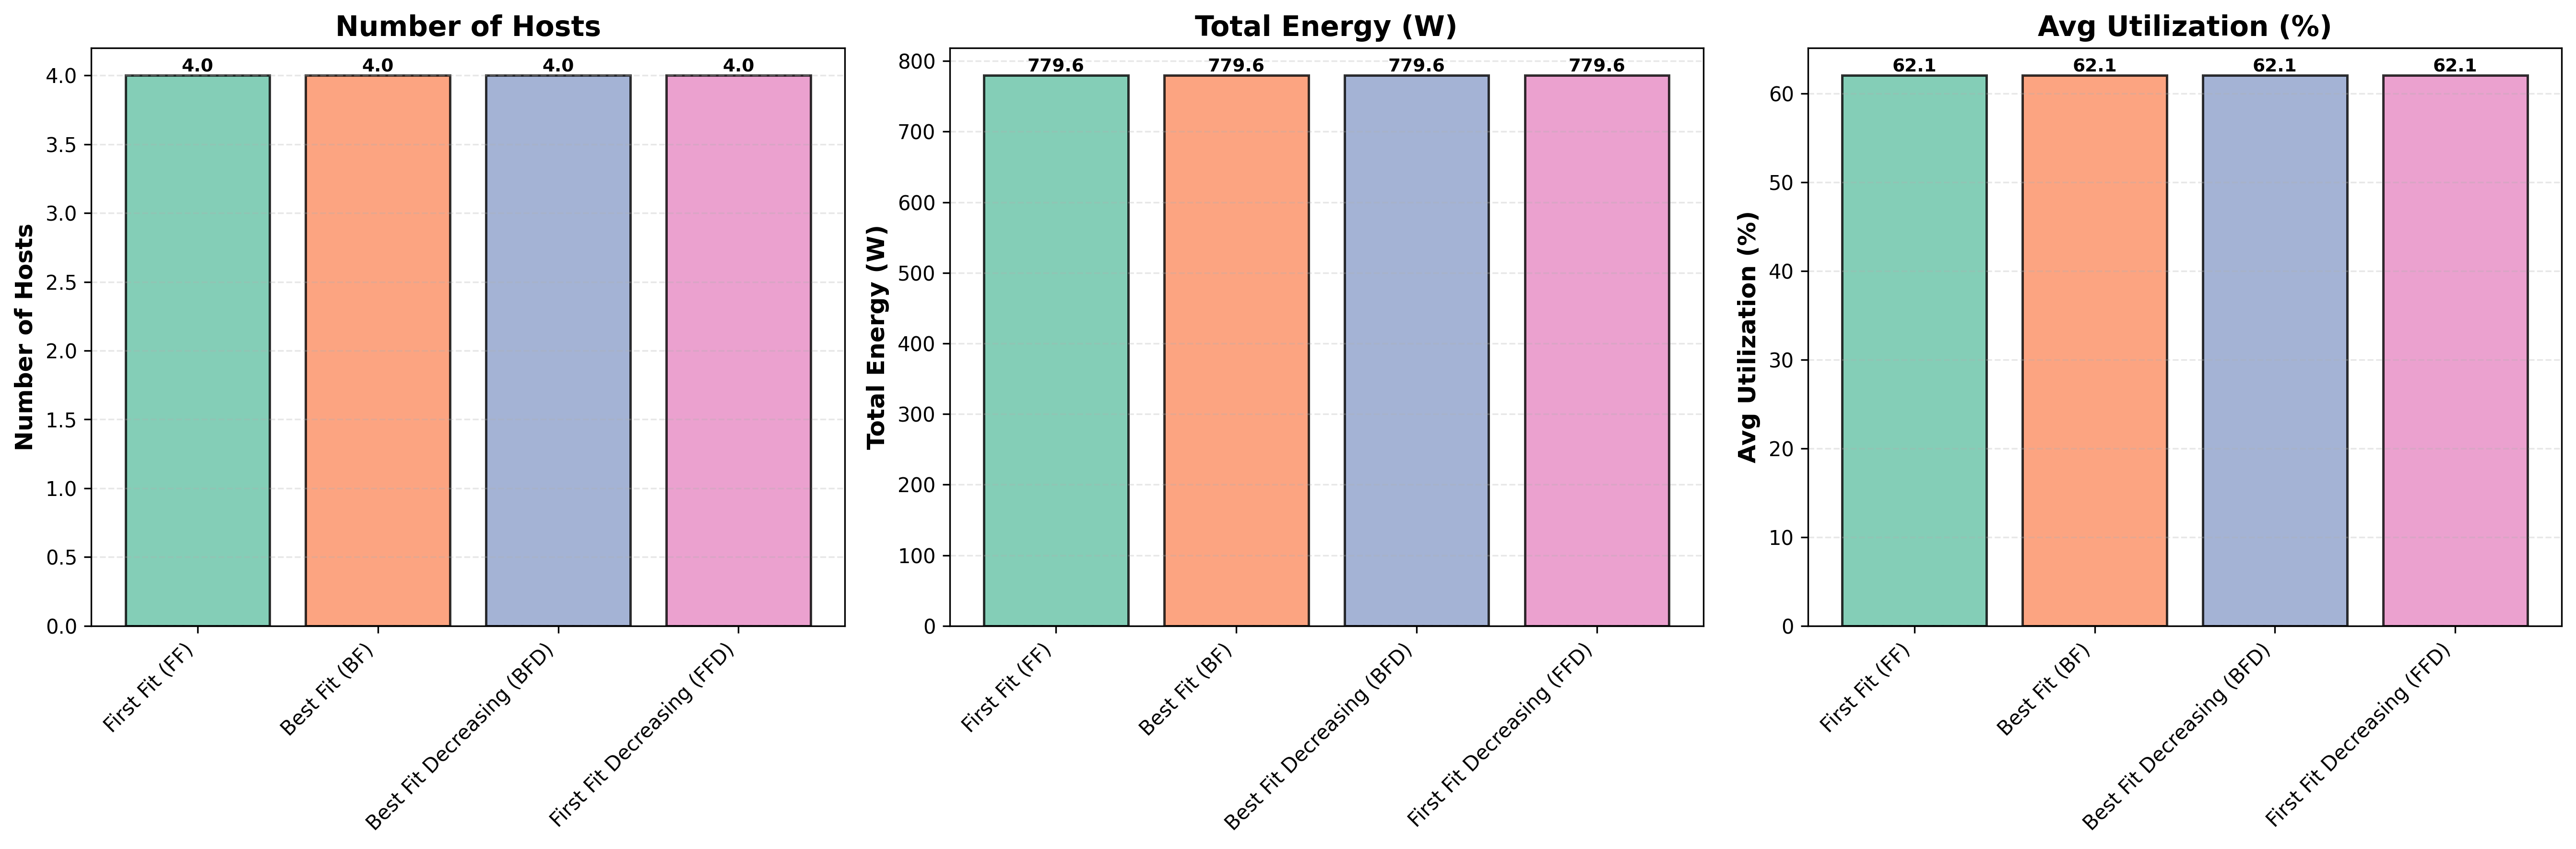

✓ Figure 8 saved: Figure8_Algorithm_Comparison.png
✓ Algorithm comparison saved to CSV



In [24]:
# ============================================================================
# CELL 20: Comparison of Different Consolidation Algorithms
# ============================================================================

def consolidate_first_fit(vm_utilizations, host_capacity=100.0, overload_threshold=80.0):
    """First Fit (FF) - no sorting"""
    hosts = []
    host_utils = []
    
    for vm_id, vm_util in vm_utilizations.items():
        placed = False
        for i, host in enumerate(hosts):
            if host_utils[i] + vm_util <= overload_threshold:
                host.append((vm_id, vm_util))
                host_utils[i] += vm_util
                placed = True
                break
        
        if not placed:
            hosts.append([(vm_id, vm_util)])
            host_utils.append(vm_util)
    
    return {
        'n_hosts': len(hosts),
        'avg_utilization': np.mean(host_utils) if host_utils else 0,
        'total_energy': sum(calculate_host_power(util) for util in host_utils),
        'sla_violations': sum(1 for util in host_utils if util > overload_threshold)
    }

def consolidate_best_fit(vm_utilizations, host_capacity=100.0, overload_threshold=80.0):
    """Best Fit (BF) - place in host with least remaining space"""
    hosts = []
    host_utils = []
    
    for vm_id, vm_util in vm_utilizations.items():
        best_idx = -1
        min_remaining = float('inf')
        
        for i, host in enumerate(hosts):
            remaining = overload_threshold - host_utils[i]
            if remaining >= vm_util and remaining < min_remaining:
                best_idx = i
                min_remaining = remaining
        
        if best_idx != -1:
            hosts[best_idx].append((vm_id, vm_util))
            host_utils[best_idx] += vm_util
        else:
            hosts.append([(vm_id, vm_util)])
            host_utils.append(vm_util)
    
    return {
        'n_hosts': len(hosts),
        'avg_utilization': np.mean(host_utils) if host_utils else 0,
        'total_energy': sum(calculate_host_power(util) for util in host_utils),
        'sla_violations': sum(1 for util in host_utils if util > overload_threshold)
    }

def consolidate_best_fit_decreasing(vm_utilizations, host_capacity=100.0, overload_threshold=80.0):
    """Best Fit Decreasing (BFD) - sort then best fit"""
    sorted_vms = sorted(vm_utilizations.items(), key=lambda x: x[1], reverse=True)
    
    hosts = []
    host_utils = []
    
    for vm_id, vm_util in sorted_vms:
        best_idx = -1
        min_remaining = float('inf')
        
        for i, host in enumerate(hosts):
            remaining = overload_threshold - host_utils[i]
            if remaining >= vm_util and remaining < min_remaining:
                best_idx = i
                min_remaining = remaining
        
        if best_idx != -1:
            hosts[best_idx].append((vm_id, vm_util))
            host_utils[best_idx] += vm_util
        else:
            hosts.append([(vm_id, vm_util)])
            host_utils.append(vm_util)
    
    return {
        'n_hosts': len(hosts),
        'avg_utilization': np.mean(host_utils) if host_utils else 0,
        'total_energy': sum(calculate_host_power(util) for util in host_utils),
        'sla_violations': sum(1 for util in host_utils if util > overload_threshold)
    }

print("="*80)
print("CONSOLIDATION ALGORITHM COMPARISON")
print("="*80)

algorithms = {
    'First Fit (FF)': consolidate_first_fit,
    'Best Fit (BF)': consolidate_best_fit,
    'Best Fit Decreasing (BFD)': consolidate_best_fit_decreasing,
    'First Fit Decreasing (FFD)': consolidate_vms  # Original
}

algo_results = []

# Use RF tuned predictions
for algo_name, algo_func in algorithms.items():
    print(f"\nTesting {algo_name}...")
    
    result = algo_func(
        rf_predictions,
        host_capacity=CONFIG['HOST_CAPACITY'],
        overload_threshold=CONFIG['OVERLOAD_THRESHOLD']
    )
    
    algo_results.append({
        'Algorithm': algo_name,
        'N_Hosts': result['n_hosts'],
        'Avg_Utilization': result['avg_utilization'],
        'Total_Energy_W': result['total_energy'],
        'SLA_Violations': result['sla_violations']
    })
    
    print(f"  Hosts: {result['n_hosts']}, Energy: {result['total_energy']:.2f}W")

algo_df = pd.DataFrame(algo_results)

print("\n" + "="*80)
print("ALGORITHM COMPARISON RESULTS")
print("="*80)
print(algo_df.to_string(index=False))
print("="*80 + "\n")

# Plot comparison
fig, axes = plt.subplots(1, 3, figsize=(18, 6), dpi=CONFIG['DPI'])

metrics_algo = ['N_Hosts', 'Total_Energy_W', 'Avg_Utilization']
titles = ['Number of Hosts', 'Total Energy (W)', 'Avg Utilization (%)']

for idx, (metric, title) in enumerate(zip(metrics_algo, titles)):
    ax = axes[idx]
    
    bars = ax.bar(range(len(algo_df)), algo_df[metric], 
                   color=sns.color_palette("Set2", len(algo_df)),
                   alpha=0.8, edgecolor='black', linewidth=1.2)
    
    ax.set_xticks(range(len(algo_df)))
    ax.set_xticklabels(algo_df['Algorithm'], rotation=45, ha='right', fontsize=10)
    ax.set_ylabel(title, fontsize=12, fontweight='bold')
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.grid(axis='y', alpha=0.3, linestyle='--')
    
    # Value labels
    for bar, val in zip(bars, algo_df[metric]):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{val:.1f}', ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.savefig('Figure8_Algorithm_Comparison.png', dpi=CONFIG['DPI'], bbox_inches='tight')
plt.show()

algo_df.to_csv('algorithm_comparison.csv', index=False)
print("✓ Figure 8 saved: Figure8_Algorithm_Comparison.png")
print("✓ Algorithm comparison saved to CSV\n")

COMPUTATIONAL COST ANALYSIS

Measuring Naive...
  Train: 0.000s, Predict: 0.000s, MAE: 5.2651

Measuring KNN-10...
  Train: 0.008s, Predict: 0.124s, MAE: 4.3161

Measuring KNN_tuned...
  Train: 0.006s, Predict: 0.207s, MAE: 4.1819

Measuring RandomForest...
  Train: 0.739s, Predict: 0.036s, MAE: 4.4261

Measuring RF_tuned...
  Train: 0.473s, Predict: 0.044s, MAE: 4.2023

Measuring XGBoost...
  Train: 0.111s, Predict: 0.004s, MAE: 4.6249

Measuring XGB_tuned...
  Train: 0.025s, Predict: 0.002s, MAE: 4.3156

Measuring LSTM...
  Train: 13.809s, Predict: 1.291s, MAE: 4.1641

COMPUTATIONAL COST SUMMARY
       Model  Train_Time_s  Train_Time_per_1k_samples_ms  Pred_Time_s  Pred_Time_per_1k_samples_ms  Test_MAE
       Naive      0.000000                      0.000000     0.000010                     0.003974  5.265079
      KNN-10      0.007896                      1.356692     0.123651                    49.067774  4.316125
   KNN_tuned      0.005871                      1.008691     0.20653

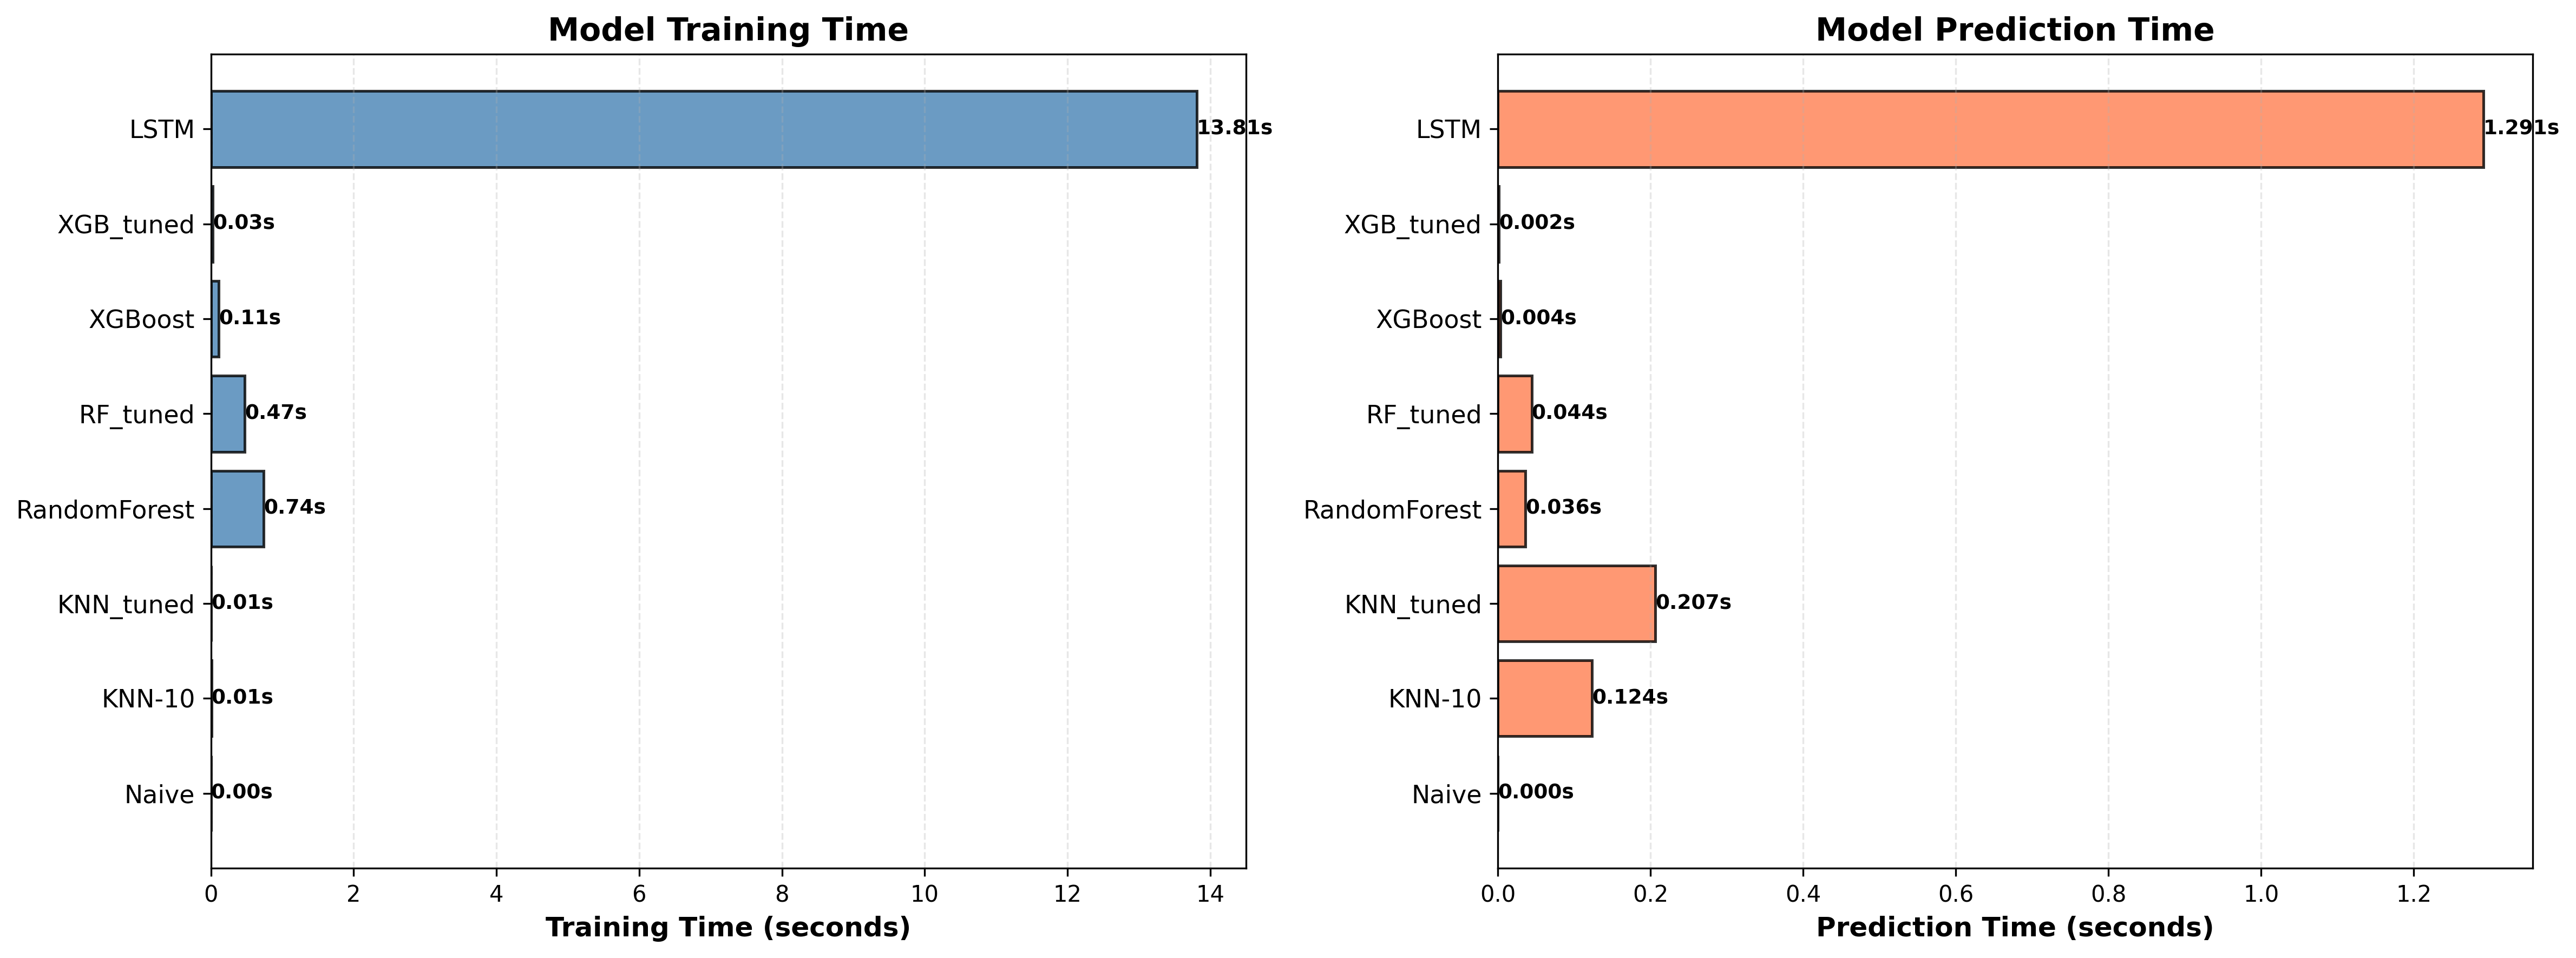

✓ Figure 9 saved: Figure9_Computational_Cost.png
✓ Computational cost saved to CSV



In [25]:
# ============================================================================
# CELL 21: Computational Cost Analysis
# ============================================================================

print("="*80)
print("COMPUTATIONAL COST ANALYSIS")
print("="*80)

X_train_cost = datasets[0]['X_train']
y_train_cost = datasets[0]['y_train']
X_test_cost = datasets[0]['X_test']
y_test_cost = datasets[0]['y_test']

cost_results = []

# Test models
cost_models = {
    'Naive': train_naive_persistence(X_train_cost, y_train_cost),
    'KNN-10': KNeighborsRegressor(n_neighbors=10, weights='distance'),
    'KNN_tuned': best_models['KNN_tuned'],
    'RandomForest': RandomForestRegressor(n_estimators=100, max_depth=15, random_state=42, n_jobs=-1),
    'RF_tuned': best_models['RF_tuned']
}

if XGBOOST_AVAILABLE:
    cost_models['XGBoost'] = xgb.XGBRegressor(n_estimators=100, max_depth=6, random_state=42, n_jobs=-1)
    cost_models['XGB_tuned'] = best_models['XGB_tuned']

for model_name, model in cost_models.items():
    print(f"\nMeasuring {model_name}...")
    
    if model_name == 'Naive':
        train_time = 0.0
        start_time = time.time()
        y_pred = predict_model(model, X_test_cost, model_type='sklearn')
        pred_time = time.time() - start_time
    else:
        # Training time
        start_time = time.time()
        model.fit(X_train_cost, y_train_cost)
        train_time = time.time() - start_time
        
        # Prediction time
        start_time = time.time()
        y_pred = model.predict(X_test_cost)
        pred_time = time.time() - start_time
    
    # Metrics
    mae = mean_absolute_error(y_test_cost, y_pred)
    
    # Per-sample times
    train_time_per_sample = (train_time / len(X_train_cost)) * 1000 if train_time > 0 else 0
    pred_time_per_sample = (pred_time / len(X_test_cost)) * 1000
    
    cost_results.append({
        'Model': model_name,
        'Train_Time_s': train_time,
        'Train_Time_per_1k_samples_ms': train_time_per_sample * 1000,
        'Pred_Time_s': pred_time,
        'Pred_Time_per_1k_samples_ms': pred_time_per_sample * 1000,
        'Test_MAE': mae
    })
    
    print(f"  Train: {train_time:.3f}s, Predict: {pred_time:.3f}s, MAE: {mae:.4f}")

# Add LSTM/GRU if available
if DEEP_LEARNING_AVAILABLE:
    print("\nMeasuring LSTM...")
    X_train_lstm = X_train_cost.reshape((X_train_cost.shape[0], X_train_cost.shape[1], 1))
    X_test_lstm = X_test_cost.reshape((X_test_cost.shape[0], X_test_cost.shape[1], 1))
    
    lstm_model = Sequential([
        LSTM(50, activation='relu', return_sequences=True, input_shape=(X_train_cost.shape[1], 1)),
        Dropout(0.2),
        LSTM(50, activation='relu'),
        Dropout(0.2),
        Dense(1)
    ])
    lstm_model.compile(optimizer='adam', loss='mse')
    
    start_time = time.time()
    lstm_model.fit(X_train_lstm, y_train_cost, epochs=20, batch_size=64, verbose=0)
    lstm_train_time = time.time() - start_time
    
    start_time = time.time()
    y_pred_lstm = lstm_model.predict(X_test_lstm, verbose=0).flatten()
    lstm_pred_time = time.time() - start_time
    
    lstm_mae = mean_absolute_error(y_test_cost, y_pred_lstm)
    
    cost_results.append({
        'Model': 'LSTM',
        'Train_Time_s': lstm_train_time,
        'Train_Time_per_1k_samples_ms': (lstm_train_time / len(X_train_cost)) * 1000000,
        'Pred_Time_s': lstm_pred_time,
        'Pred_Time_per_1k_samples_ms': (lstm_pred_time / len(X_test_cost)) * 1000000,
        'Test_MAE': lstm_mae
    })
    
    print(f"  Train: {lstm_train_time:.3f}s, Predict: {lstm_pred_time:.3f}s, MAE: {lstm_mae:.4f}")

cost_df = pd.DataFrame(cost_results)

print("\n" + "="*80)
print("COMPUTATIONAL COST SUMMARY")
print("="*80)
print(cost_df.to_string(index=False))
print("="*80 + "\n")

# Plot
fig, axes = plt.subplots(1, 2, figsize=(16, 6), dpi=CONFIG['DPI'])

# Training time
ax = axes[0]
bars = ax.barh(range(len(cost_df)), cost_df['Train_Time_s'],
               color='steelblue', alpha=0.8, edgecolor='black', linewidth=1.2)
ax.set_yticks(range(len(cost_df)))
ax.set_yticklabels(cost_df['Model'], fontsize=11)
ax.set_xlabel('Training Time (seconds)', fontsize=12, fontweight='bold')
ax.set_title('Model Training Time', fontsize=14, fontweight='bold')
ax.grid(axis='x', alpha=0.3, linestyle='--')

for bar, val in zip(bars, cost_df['Train_Time_s']):
    ax.text(val, bar.get_y() + bar.get_height()/2, f'{val:.2f}s',
            ha='left', va='center', fontsize=9, fontweight='bold')

# Prediction time
ax = axes[1]
bars = ax.barh(range(len(cost_df)), cost_df['Pred_Time_s'],
               color='coral', alpha=0.8, edgecolor='black', linewidth=1.2)
ax.set_yticks(range(len(cost_df)))
ax.set_yticklabels(cost_df['Model'], fontsize=11)
ax.set_xlabel('Prediction Time (seconds)', fontsize=12, fontweight='bold')
ax.set_title('Model Prediction Time', fontsize=14, fontweight='bold')
ax.grid(axis='x', alpha=0.3, linestyle='--')

for bar, val in zip(bars, cost_df['Pred_Time_s']):
    ax.text(val, bar.get_y() + bar.get_height()/2, f'{val:.3f}s',
            ha='left', va='center', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.savefig('Figure9_Computational_Cost.png', dpi=CONFIG['DPI'], bbox_inches='tight')
plt.show()

cost_df.to_csv('computational_cost.csv', index=False)
print("✓ Figure 9 saved: Figure9_Computational_Cost.png")
print("✓ Computational cost saved to CSV\n")

In [26]:
# ============================================================================
# CELL 22: Final Advanced Analysis Summary
# ============================================================================

print("="*80)
print("FINAL ADVANCED ANALYSIS SUMMARY")
print("="*80)

print("\n1. HYPERPARAMETER TUNING")
print("-" * 80)
print(tuning_df[['Model', 'CV_MAE', 'Test_MAE']].to_string(index=False))

print("\n2. CROSS-VALIDATION (5-Fold TimeSeriesSplit)")
print("-" * 80)
print(cv_results_df[['Model', 'CV_MAE_mean', 'CV_MAE_std']].to_string(index=False))

print("\n3. FEATURE IMPORTANCE (Top 3)")
print("-" * 80)
print(importance_df.head(3).to_string(index=False))

print("\n4. SENSITIVITY ANALYSIS (Threshold Impact)")
print("-" * 80)
threshold_impact = sensitivity_df.groupby('Model').agg({
    'N_Hosts': lambda x: f"{x.min()}-{x.max()}",
    'Total_Energy_W': lambda x: f"{x.min():.1f}-{x.max():.1f}"
})
print(threshold_impact.to_string())

print("\n5. CONSOLIDATION ALGORITHM COMPARISON")
print("-" * 80)
print(algo_df[['Algorithm', 'N_Hosts', 'Total_Energy_W']].to_string(index=False))

print("\n6. COMPUTATIONAL COST (Top 3 Fastest)")
print("-" * 80)
print(cost_df.nsmallest(3, 'Train_Time_s')[['Model', 'Train_Time_s', 'Test_MAE']].to_string(index=False))

print("\n" + "="*80)
print("✓✓✓ ADVANCED ANALYSIS COMPLETE ✓✓✓")
print("="*80)

print("\nNew files generated:")
print("  - hyperparameter_tuning_results.csv")
print("  - deep_learning_architecture_search.csv")
print("  - cross_validation_results.csv")
print("  - feature_importance.csv")
print("  - sensitivity_analysis.csv")
print("  - algorithm_comparison.csv")
print("  - computational_cost.csv")
print("  - Figure6_Feature_Importance.png")
print("  - Figure7_Sensitivity_Analysis.png")
print("  - Figure8_Algorithm_Comparison.png")
print("  - Figure9_Computational_Cost.png")

FINAL ADVANCED ANALYSIS SUMMARY

1. HYPERPARAMETER TUNING
--------------------------------------------------------------------------------
       Model   CV_MAE  Test_MAE
         KNN 3.999291  4.181886
RandomForest 3.972141  4.202320
     XGBoost 4.101697  4.315631

2. CROSS-VALIDATION (5-Fold TimeSeriesSplit)
--------------------------------------------------------------------------------
       Model  CV_MAE_mean  CV_MAE_std
    RF_tuned     5.313371    2.369564
   XGB_tuned     5.405204    2.309776
   KNN_tuned     5.526214    2.585176
RandomForest     5.573816    2.104707
      KNN-10     5.743179    2.519471
     XGBoost     6.140395    2.542170

3. FEATURE IMPORTANCE (Top 3)
--------------------------------------------------------------------------------
Feature  RF_Importance  XGB_Importance
 u(t-2)       0.145693        0.143096
 u(t-1)       0.141065        0.182160
 u(t-6)       0.128265        0.118389

4. SENSITIVITY ANALYSIS (Threshold Impact)
----------------------------